# AI Learns to play Dino game!

In [4]:
# Importing Libraries

# Bread and butter
import numpy as np
import matplotlib.pyplot as plt

# Importing Selenium to control the browser
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options

# To use our keyboard
import pyautogui

# To help me become Doctor Strange
import time

# Because I can't do Image processing myself
import cv2 

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Deque for storing experiences
from collections import deque

# Just a random import
import random

# To make for loops look cool
from tqdm import tqdm

In [5]:
# Pur environment class which is used to play the game
class Environment():

    def __init__(self, device="cpu", chrome_path=".//Driver/chromedriver.exe"):
        self.done = False
        self.device = device
        self.initialize_chrome(chrome_path)
        
    def initialize_chrome(self, chrome_path):
        chrome_options = Options()
        chrome_options.add_argument("start-maximized")
        chrome_options.add_argument("disable-infobars")
        chrome_options.add_argument("--mute-audio")
        self.driver = webdriver.Chrome(chrome_path, chrome_options=chrome_options)
        
    def reset(self, game_url="chrome://dino"):
        try:
            self.driver.get(game_url)
        except:
            pass
    
    def start(self):
        pyautogui.press("up")

    # Hard stop
    def close_all(self):
        self.driver.close()
        self.driver.quit()
        try:
            os.system("cmd /c taskkill /F /IM chromedriver.exe")
        except:
            print("No tasks found!")
    

    def get_screenshot(self, screenshot_path=".//Screenshots/"):
        current_state = []
        for i in range(1, 5):
            file_name = screenshot_path + str(i) + '.jpg'
            screenshot = pyautogui.screenshot(region=(0, 400, 1920, 330))
            screenshot.save(file_name)
            image_tensor = self.process_image(file_name)
            current_state.append(image_tensor)
        current_state = torch.cat(current_state).unsqueeze(0).to(self.device)
        return current_state

    def process_image(self, image_file):
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image[image>255] = 255
        image = cv2.resize(image, (256, 128))
        image = cv2.Canny(image, threshold1=100, threshold2=200)
        image = np.reshape(image, (1, 256, 128))
        return self.image_to_tensor(image)

    def image_to_tensor(self, image):
        image = image.astype(np.float32)
        image_tensor = torch.from_numpy(image)
        image_tensor = image_tensor.to(self.device, dtype=torch.float32)
        return image_tensor


    def jump(self):
        pyautogui.keyDown("up")
        time.sleep(0.25)
        pyautogui.keyUp("up")


    def duck(self):
        pyautogui.keyDown("down")
        time.sleep(0.25)
        pyautogui.keyUp("down")


    def do_nothing(self):
        pass


    def take_action(self, action):
        reward = 1
        if action == 0:
            self.jump()
        elif action == 1:
            self.duck()
        elif action == 2:
            self.do_nothing()
        
        state = self.get_screenshot()
        score = self.get_score()
        reward = 0.1*score / 11
        done = False
        
        if self.is_crashed():
            reward = -11/score
            done = True
            
        return state, reward, done
        
        
    def get_score(self):
        score_array = self.driver.execute_script("return Runner.instance_.distanceMeter.digits")
        score = "".join(score_array)
        return int(score)
        
        
    def view_screenshots(self, images):
        # images are of the shape (1, 4, 256, 128)
        images = torch.reshape(images, shape=(4, 128, 256))
        
        fig, ax = plt.subplots(2, 2, figsize=(14, 14))
        x = 0
        for i in range(2):
            for j in range(2):
                ax[i][j].imshow(images[x], cmap="gray")
                ax[i][j].set_title(f"Screenshot #{x}")
                x += 1
        
                
    def is_crashed(self):
        return self.driver.execute_script("return Runner.instance_.crashed")

In [6]:
class DinoNetwork(nn.Module):
    def __init__(self):
        super(DinoNetwork, self).__init__()
        # First Conv Layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=5, stride=3),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(2304, 64),
            nn.ReLU()
            # nn.BatchNorm1d(2304)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(64, 3),
            nn.ReLU()
            
        )

    def forward(self, inputs):
        # print(f"Dimensions of input are {inputs.shape}")
        x = self.conv1(inputs)
        # print(f"Dimensions after 1st Conv Layer are {x.shape}")
        x = self.conv2(x)
        x = self.conv3(x)
        # We will now flatten the layers
        # Calculated using this below line
        x = x.flatten(start_dim=1, end_dim=-1)
        # print(f"After flattening, shape is {x.shape}")
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    




In [7]:
# Some Utlitity functions

# Save a model
def save_model(model_values):
    """
    Model Values is a dictionary of the following format
    dict = {
        'model_dict': policy_net.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'epsilon': epsilon
    }
    """
    f_path = ".//v2_models/model.pt"
    torch.save(model_values, f_path)
    

def load_model(model_values_path, model, optimizer):
    model_values = torch.load(model_values_path)
    model.load_state_dict(model_values['state_dict'])
    optimizer.load_state_dict(model_values['optimizer'])
    epsilon = model_values['epsilon']
    return model, optimizer, epsilon
    
    
# Initializing weights
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        # Kaimig Uniform initialization is used for Relu Activation. It's mostly known as 'He weight initialization'.
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

In [8]:
# Defining Constants
batch_size = 128

# Gamma (Discount rate for future rewards)
gamma = 0.95

# Exploration rate
epsilon_start = 1
epsilon = 1

# Decay rate for Epsilon
epsilon_decay = 0.995

# Minimum Epsilon
epsilon_min = 0.01

# Updating the Target Q Network after these many episodes
target_update = 40

# Selecting the device for the iterations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setting loss criteria
criterion = nn.MSELoss()

# Setting the learning rate
lr = 1e-4

# Setting memory size for replay memory
replay_memory_size = 50_000

# Initalizing deque for storing experiences
replay_memory = deque()

# Setting the Number of episodes
num_episodes = 2000

# Defining our models
policy_net = DinoNetwork().to(device)
policy_net.apply(init_weights)

target_net = DinoNetwork().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr) 

#Setting number of actions
n_actions = 3

In [9]:
agent_loss = []
epsilon_trend=[]
def train(policy_net, target_net, optimizer, epsilon, resume_training=False, model_path=None, device='cpu'):
    # If the parameter 'resume_training' is set to True, we have to load a pre-trained model
    if resume_training:
        target_net, optimizer, epsilon = load_model(model_path, target_net, optimizer)
        policy_net.load_state_dict(target_net.state_dict())
        target_net.eval()
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
    
    #Creating objects
    env = Environment(device=device)
    
    # Training loop
    for episode in tqdm(range(num_episodes)):
        env.reset()
        env.jump()
        done = False

        # Sleep time till the first obstacle arrives
        time.sleep(4)
        state = env.get_screenshot()
        while not done:
            random_number = random.random()

            if random_number <= epsilon: # Randomly explore
                action = random.randrange(n_actions)
            else: # Predict the action
                q_values = target_net(state) 
                action = torch.argmax(q_values)

            # Get experience from the environment
            next_state, reward, done = env.take_action(action)
            action_tensor = torch.tensor(action, dtype=torch.int64, device=device)
            reward_tensor = torch.tensor(reward, dtype=torch.int16, device=device)
            done_tensor = torch.tensor(done, dtype=torch.bool, device=device)

            if len(replay_memory) > replay_memory_size:
                replay_memory.popleft()

            replay_memory.append((state, action_tensor, reward_tensor, next_state, done_tensor))
            
        # Sufficient data has been gathered to train the model
        if len(replay_memory) > batch_size:
            minibatch = random.sample(replay_memory, batch_size)

            # Output Value placeholder (batch_size*number of actions)
            targets = torch.zeros((batch_size, 3)).to(device)
            prediction = torch.zeros((batch_size, 3)).to(device)
            states = torch.zeros((batch_size))
            
            for i in range(len(minibatch)):
                state = minibatch[i][0]
                action = minibatch[i][1]
                reward = minibatch[i][2]
                next_state = minibatch[i][3]
                done = minibatch[i][4]
                targets[i] = target_net(state)
                prediction[i] = target_net(state)

                if done:
                    targets[i, action] = reward
                    print(f"")
                else:
                    targets[i, action] = reward + gamma*torch.max(target_net(next_state))

            # print(f"Sample prediction: {prediction.data}")
            # print(f"Sample Target: {targets.data}")
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            state = next_state
            
            # Recording loss for scientific purposes
            agent_loss.append((loss/batch_size).item())

            # Saving our model after 150 episodes
            if episode % 150 == 0:
                model_values = {
                    'state_dict': target_net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epsilon': epsilon
                }
                save_model(model_values)

            # Updating target_net after a pre-determined number of episodes
            if episode % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())


        # Decaying epsilon to promote exploitation
        epsilon = max(epsilon*epsilon_decay, epsilon_min)
        epsilon_trend.append(epsilon)
        
        
        
    

In [10]:
train(policy_net, target_net, optimizer, epsilon, resume_training=True, model_path='.//v2_models/model-2000E_128BS.pt', device=device)

D:\Programming\Python\Environments\py3.7_envs\AiPlaysDino\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: use options instead of chrome_options
  
  2%|█▊                                                                            | 48/2000 [05:21<3:37:27,  6.68s/it]

  2%|█▉                                                                            | 49/2000 [05:28<3:40:02,  6.77s/it]

  2%|█▉                                                                            | 50/2000 [05:35<3:41:04,  6.80s/it]

  3%|█▉                                                                            | 51/2000 [05:42<3:39:37,  6.76s/it]

  3%|██                                                                            | 52/2000 [05:48<3:35:26,  6.64s/it]

  3%|██                                                                            | 53/2000 [05:55<3:36:06,  6.66s/it]

  3%|██                                                                            | 54/2000 [06:02<3:43:46,  6.90s/it]

  3%|██▏                                                                           | 55/2000 [06:09<3:41:38,  6.84s/it]

  3%|██▏                                                                           | 56/2000 [06:16<3:47:17,  7.01s/it]

  3%|██▏                                                                           | 57/2000 [06:23<3:44:01,  6.92s/it]

  3%|██▎                                                                           | 58/2000 [06:32<4:02:28,  7.49s/it]

  3%|██▎                                                                           | 59/2000 [06:39<3:54:23,  7.25s/it]

  3%|██▎                                                                           | 60/2000 [06:48<4:10:14,  7.74s/it]

  3%|██▍                                                                           | 61/2000 [06:54<3:59:41,  7.42s/it]

  3%|██▍                                                                           | 62/2000 [07:02<4:00:11,  7.44s/it]

  3%|██▍                                                                           | 63/2000 [07:08<3:53:45,  7.24s/it]

  3%|██▍                                                                           | 64/2000 [07:15<3:48:27,  7.08s/it]

  3%|██▌                                                                           | 65/2000 [07:22<3:45:18,  6.99s/it]

  3%|██▌                                                                           | 66/2000 [07:29<3:42:18,  6.90s/it]

  3%|██▌                                                                           | 67/2000 [07:38<4:10:11,  7.77s/it]

  3%|██▋                                                                           | 68/2000 [07:45<3:59:49,  7.45s/it]

  3%|██▋                                                                           | 69/2000 [07:52<3:52:40,  7.23s/it]

  4%|██▋                                                                           | 70/2000 [08:00<4:02:02,  7.52s/it]

  4%|██▊                                                                           | 71/2000 [08:07<4:00:46,  7.49s/it]

  4%|██▊                                                                           | 72/2000 [08:14<3:52:54,  7.25s/it]

  4%|██▊                                                                           | 73/2000 [08:22<3:54:20,  7.30s/it]

  4%|██▉                                                                           | 74/2000 [08:28<3:48:48,  7.13s/it]

  4%|██▉                                                                           | 75/2000 [08:35<3:44:40,  7.00s/it]

  4%|██▉                                                                           | 76/2000 [08:43<3:55:16,  7.34s/it]

  4%|███                                                                           | 77/2000 [08:50<3:48:41,  7.14s/it]

  4%|███                                                                           | 78/2000 [09:00<4:18:35,  8.07s/it]

  4%|███                                                                           | 79/2000 [09:07<4:05:14,  7.66s/it]

  4%|███                                                                           | 80/2000 [09:14<4:02:37,  7.58s/it]

  4%|███▏                                                                          | 81/2000 [09:21<3:53:51,  7.31s/it]

  4%|███▏                                                                          | 82/2000 [09:27<3:47:49,  7.13s/it]

  4%|███▏                                                                          | 83/2000 [09:34<3:43:25,  6.99s/it]

  4%|███▎                                                                          | 84/2000 [09:41<3:40:20,  6.90s/it]

  4%|███▎                                                                          | 85/2000 [09:48<3:37:55,  6.83s/it]

  4%|███▎                                                                          | 86/2000 [09:55<3:45:42,  7.08s/it]

  4%|███▍                                                                          | 87/2000 [10:02<3:41:40,  6.95s/it]

  4%|███▍                                                                          | 88/2000 [10:09<3:39:11,  6.88s/it]

  4%|███▍                                                                          | 89/2000 [10:16<3:44:27,  7.05s/it]

  4%|███▌                                                                          | 90/2000 [10:23<3:40:49,  6.94s/it]

  5%|███▌                                                                          | 91/2000 [10:29<3:38:02,  6.85s/it]

  5%|███▌                                                                          | 92/2000 [10:37<3:50:31,  7.25s/it]

  5%|███▋                                                                          | 93/2000 [10:44<3:44:52,  7.08s/it]

  5%|███▋                                                                          | 94/2000 [10:51<3:41:56,  6.99s/it]

  5%|███▋                                                                          | 95/2000 [10:58<3:38:50,  6.89s/it]

  5%|███▋                                                                          | 96/2000 [11:06<3:50:16,  7.26s/it]

  5%|███▊                                                                          | 97/2000 [11:13<3:52:18,  7.32s/it]

  5%|███▊                                                                          | 98/2000 [11:23<4:13:29,  8.00s/it]

  5%|███▊                                                                          | 99/2000 [11:32<4:21:00,  8.24s/it]

  5%|███▊                                                                         | 100/2000 [11:38<4:05:51,  7.76s/it]

  5%|███▉                                                                         | 101/2000 [11:45<3:56:02,  7.46s/it]

  5%|███▉                                                                         | 102/2000 [11:52<3:48:25,  7.22s/it]

  5%|███▉                                                                         | 103/2000 [11:58<3:42:57,  7.05s/it]

  5%|████                                                                         | 104/2000 [12:05<3:38:59,  6.93s/it]

  5%|████                                                                         | 105/2000 [12:12<3:43:52,  7.09s/it]

  5%|████                                                                         | 106/2000 [12:23<4:13:54,  8.04s/it]

  5%|████                                                                         | 107/2000 [12:29<4:01:19,  7.65s/it]

  5%|████▏                                                                        | 108/2000 [12:36<3:52:16,  7.37s/it]

  5%|████▏                                                                        | 109/2000 [12:43<3:45:57,  7.17s/it]

  6%|████▏                                                                        | 110/2000 [12:50<3:41:09,  7.02s/it]

  6%|████▎                                                                        | 111/2000 [12:56<3:37:46,  6.92s/it]

  6%|████▎                                                                        | 112/2000 [13:05<3:55:33,  7.49s/it]

  6%|████▎                                                                        | 113/2000 [13:13<4:01:47,  7.69s/it]

  6%|████▍                                                                        | 114/2000 [13:20<3:51:54,  7.38s/it]

  6%|████▍                                                                        | 115/2000 [13:26<3:45:03,  7.16s/it]

  6%|████▍                                                                        | 116/2000 [13:35<4:01:04,  7.68s/it]

  6%|████▌                                                                        | 117/2000 [13:42<3:51:41,  7.38s/it]

  6%|████▌                                                                        | 118/2000 [13:48<3:42:15,  7.09s/it]

  6%|████▌                                                                        | 119/2000 [13:55<3:38:12,  6.96s/it]

  6%|████▌                                                                        | 120/2000 [14:02<3:35:10,  6.87s/it]

  6%|████▋                                                                        | 121/2000 [14:08<3:33:01,  6.80s/it]

  6%|████▋                                                                        | 122/2000 [14:15<3:31:44,  6.77s/it]

  6%|████▋                                                                        | 123/2000 [14:22<3:37:41,  6.96s/it]

  6%|████▊                                                                        | 124/2000 [14:29<3:37:23,  6.95s/it]

  6%|████▊                                                                        | 125/2000 [14:37<3:43:08,  7.14s/it]

  6%|████▊                                                                        | 126/2000 [14:44<3:44:33,  7.19s/it]

  6%|████▉                                                                        | 127/2000 [14:52<3:46:15,  7.25s/it]

  6%|████▉                                                                        | 128/2000 [14:59<3:48:10,  7.31s/it]

  6%|████▉                                                                        | 129/2000 [15:07<3:48:48,  7.34s/it]

  6%|█████                                                                        | 130/2000 [15:14<3:48:26,  7.33s/it]

  7%|█████                                                                        | 131/2000 [15:21<3:48:59,  7.35s/it]

  7%|█████                                                                        | 132/2000 [15:29<3:48:24,  7.34s/it]

  7%|█████                                                                        | 133/2000 [15:37<4:02:52,  7.81s/it]

  7%|█████▏                                                                       | 134/2000 [15:45<3:58:07,  7.66s/it]

  7%|█████▏                                                                       | 135/2000 [15:54<4:09:25,  8.02s/it]

  7%|█████▏                                                                       | 136/2000 [16:05<4:40:47,  9.04s/it]

  7%|█████▎                                                                       | 137/2000 [16:12<4:25:41,  8.56s/it]

  7%|█████▎                                                                       | 138/2000 [16:25<5:05:39,  9.85s/it]

  7%|█████▎                                                                       | 139/2000 [16:33<4:42:00,  9.09s/it]

  7%|█████▍                                                                       | 140/2000 [16:42<4:40:12,  9.04s/it]

  7%|█████▍                                                                       | 141/2000 [16:49<4:23:57,  8.52s/it]

  7%|█████▍                                                                       | 142/2000 [16:56<4:12:49,  8.16s/it]

  7%|█████▌                                                                       | 143/2000 [17:11<5:11:24, 10.06s/it]

  7%|█████▌                                                                       | 144/2000 [17:18<4:40:52,  9.08s/it]

  7%|█████▌                                                                       | 145/2000 [17:25<4:24:55,  8.57s/it]

  7%|█████▌                                                                       | 146/2000 [17:32<4:13:08,  8.19s/it]

  7%|█████▋                                                                       | 147/2000 [17:39<3:58:18,  7.72s/it]

  7%|█████▋                                                                       | 148/2000 [17:46<3:49:45,  7.44s/it]

  7%|█████▋                                                                       | 149/2000 [17:53<3:48:01,  7.39s/it]

  8%|█████▊                                                                       | 150/2000 [18:00<3:47:04,  7.36s/it]

  8%|█████▊                                                                       | 151/2000 [18:07<3:42:40,  7.23s/it]

  8%|█████▊                                                                       | 152/2000 [18:15<3:51:40,  7.52s/it]

  8%|█████▉                                                                       | 153/2000 [18:27<4:26:41,  8.66s/it]

  8%|█████▉                                                                       | 154/2000 [18:34<4:14:11,  8.26s/it]

  8%|█████▉                                                                       | 155/2000 [18:41<4:05:24,  7.98s/it]

  8%|██████                                                                       | 156/2000 [18:48<3:55:41,  7.67s/it]

  8%|██████                                                                       | 157/2000 [18:56<3:52:41,  7.58s/it]

  8%|██████                                                                       | 158/2000 [19:03<3:50:02,  7.49s/it]

  8%|██████                                                                       | 159/2000 [19:10<3:48:49,  7.46s/it]

  8%|██████▏                                                                      | 160/2000 [19:18<3:47:53,  7.43s/it]

  8%|██████▏                                                                      | 161/2000 [19:26<3:54:01,  7.64s/it]

  8%|██████▏                                                                      | 162/2000 [19:36<4:20:48,  8.51s/it]

  8%|██████▎                                                                      | 163/2000 [19:44<4:09:53,  8.16s/it]

  8%|██████▎                                                                      | 164/2000 [19:52<4:09:48,  8.16s/it]

  8%|██████▎                                                                      | 165/2000 [20:02<4:23:45,  8.62s/it]

  8%|██████▍                                                                      | 166/2000 [20:08<4:07:33,  8.10s/it]

  8%|██████▍                                                                      | 167/2000 [20:16<4:00:06,  7.86s/it]

  8%|██████▍                                                                      | 168/2000 [20:23<3:55:18,  7.71s/it]

  8%|██████▌                                                                      | 169/2000 [20:30<3:52:26,  7.62s/it]

  8%|██████▌                                                                      | 170/2000 [20:38<3:49:36,  7.53s/it]

  9%|██████▌                                                                      | 171/2000 [20:48<4:09:56,  8.20s/it]

  9%|██████▌                                                                      | 172/2000 [20:55<4:02:16,  7.95s/it]

  9%|██████▋                                                                      | 173/2000 [21:02<3:56:40,  7.77s/it]

  9%|██████▋                                                                      | 174/2000 [21:10<3:53:10,  7.66s/it]

  9%|██████▋                                                                      | 175/2000 [21:17<3:46:23,  7.44s/it]

  9%|██████▊                                                                      | 176/2000 [21:24<3:45:24,  7.41s/it]

  9%|██████▊                                                                      | 177/2000 [21:31<3:45:27,  7.42s/it]

  9%|██████▊                                                                      | 178/2000 [21:38<3:39:06,  7.22s/it]

  9%|██████▉                                                                      | 179/2000 [21:45<3:40:18,  7.26s/it]

  9%|██████▉                                                                      | 180/2000 [21:52<3:37:15,  7.16s/it]

  9%|██████▉                                                                      | 181/2000 [22:00<3:38:50,  7.22s/it]

  9%|███████                                                                      | 182/2000 [22:11<4:16:23,  8.46s/it]

  9%|███████                                                                      | 183/2000 [22:19<4:06:54,  8.15s/it]

  9%|███████                                                                      | 184/2000 [22:28<4:14:42,  8.42s/it]

  9%|███████                                                                      | 185/2000 [22:35<4:05:02,  8.10s/it]

  9%|███████▏                                                                     | 186/2000 [22:42<3:59:03,  7.91s/it]

  9%|███████▏                                                                     | 187/2000 [22:55<4:45:15,  9.44s/it]

  9%|███████▏                                                                     | 188/2000 [23:03<4:26:13,  8.82s/it]

  9%|███████▎                                                                     | 189/2000 [23:10<4:13:37,  8.40s/it]

 10%|███████▎                                                                     | 190/2000 [23:18<4:04:31,  8.11s/it]

 10%|███████▎                                                                     | 191/2000 [23:25<3:53:49,  7.76s/it]

 10%|███████▍                                                                     | 192/2000 [23:31<3:45:26,  7.48s/it]

 10%|███████▍                                                                     | 193/2000 [23:42<4:13:25,  8.41s/it]

 10%|███████▍                                                                     | 194/2000 [23:49<4:03:51,  8.10s/it]

 10%|███████▌                                                                     | 195/2000 [23:57<3:57:12,  7.89s/it]

 10%|███████▌                                                                     | 196/2000 [24:04<3:53:18,  7.76s/it]

 10%|███████▌                                                                     | 197/2000 [24:12<3:49:21,  7.63s/it]

 10%|███████▌                                                                     | 198/2000 [24:26<4:51:34,  9.71s/it]

 10%|███████▋                                                                     | 199/2000 [24:34<4:31:06,  9.03s/it]

 10%|███████▋                                                                     | 200/2000 [24:41<4:16:15,  8.54s/it]

 10%|███████▋                                                                     | 201/2000 [24:48<4:05:41,  8.19s/it]

 10%|███████▊                                                                     | 202/2000 [24:55<3:53:52,  7.80s/it]

 10%|███████▊                                                                     | 203/2000 [25:04<4:04:51,  8.18s/it]

 10%|███████▊                                                                     | 204/2000 [25:12<3:57:48,  7.94s/it]

 10%|███████▉                                                                     | 205/2000 [25:19<3:52:31,  7.77s/it]

 10%|███████▉                                                                     | 206/2000 [25:27<3:49:35,  7.68s/it]

 10%|███████▉                                                                     | 207/2000 [25:34<3:47:03,  7.60s/it]

 10%|████████                                                                     | 208/2000 [25:41<3:44:50,  7.53s/it]

 10%|████████                                                                     | 209/2000 [25:49<3:43:07,  7.47s/it]

 10%|████████                                                                     | 210/2000 [25:56<3:42:19,  7.45s/it]

 11%|████████                                                                     | 211/2000 [26:03<3:37:00,  7.28s/it]

 11%|████████▏                                                                    | 212/2000 [26:11<3:45:35,  7.57s/it]

 11%|████████▏                                                                    | 213/2000 [26:19<3:43:41,  7.51s/it]

 11%|████████▏                                                                    | 214/2000 [26:30<4:18:29,  8.68s/it]

 11%|████████▎                                                                    | 215/2000 [26:37<4:06:39,  8.29s/it]

 11%|████████▎                                                                    | 216/2000 [26:45<3:58:27,  8.02s/it]

 11%|████████▎                                                                    | 217/2000 [26:52<3:53:15,  7.85s/it]

 11%|████████▍                                                                    | 218/2000 [26:59<3:44:17,  7.55s/it]

 11%|████████▍                                                                    | 219/2000 [27:06<3:37:35,  7.33s/it]

 11%|████████▍                                                                    | 220/2000 [27:13<3:37:42,  7.34s/it]

 11%|████████▌                                                                    | 221/2000 [27:22<3:52:43,  7.85s/it]

 11%|████████▌                                                                    | 222/2000 [27:30<3:48:58,  7.73s/it]

 11%|████████▌                                                                    | 223/2000 [27:37<3:41:15,  7.47s/it]

 11%|████████▌                                                                    | 224/2000 [27:45<3:47:36,  7.69s/it]

 11%|████████▋                                                                    | 225/2000 [27:55<4:13:27,  8.57s/it]

 11%|████████▋                                                                    | 226/2000 [28:08<4:45:46,  9.67s/it]

 11%|████████▋                                                                    | 227/2000 [28:15<4:25:04,  8.97s/it]

 11%|████████▊                                                                    | 228/2000 [28:22<4:10:42,  8.49s/it]

 11%|████████▊                                                                    | 229/2000 [28:31<4:14:59,  8.64s/it]

 12%|████████▊                                                                    | 230/2000 [28:39<4:04:24,  8.28s/it]

 12%|████████▉                                                                    | 231/2000 [28:50<4:31:07,  9.20s/it]

 12%|████████▉                                                                    | 232/2000 [28:57<4:14:58,  8.65s/it]

 12%|████████▉                                                                    | 233/2000 [29:05<4:03:41,  8.27s/it]

 12%|█████████                                                                    | 234/2000 [29:12<3:55:45,  8.01s/it]

 12%|█████████                                                                    | 235/2000 [29:19<3:45:04,  7.65s/it]

 12%|█████████                                                                    | 236/2000 [29:26<3:42:28,  7.57s/it]

 12%|█████████                                                                    | 237/2000 [29:35<3:54:45,  7.99s/it]

 12%|█████████▏                                                                   | 238/2000 [29:46<4:17:50,  8.78s/it]

 12%|█████████▏                                                                   | 239/2000 [29:57<4:33:56,  9.33s/it]

 12%|█████████▏                                                                   | 240/2000 [30:04<4:16:23,  8.74s/it]

 12%|█████████▎                                                                   | 241/2000 [30:12<4:05:27,  8.37s/it]

 12%|█████████▎                                                                   | 242/2000 [30:20<4:03:17,  8.30s/it]

 12%|█████████▎                                                                   | 243/2000 [30:27<3:55:02,  8.03s/it]

 12%|█████████▍                                                                   | 244/2000 [30:35<3:49:46,  7.85s/it]

 12%|█████████▍                                                                   | 245/2000 [30:48<4:41:45,  9.63s/it]

 12%|█████████▍                                                                   | 246/2000 [30:59<4:50:06,  9.92s/it]

 12%|█████████▌                                                                   | 247/2000 [31:06<4:27:28,  9.15s/it]

 12%|█████████▌                                                                   | 248/2000 [31:14<4:12:56,  8.66s/it]

 12%|█████████▌                                                                   | 249/2000 [31:21<4:01:42,  8.28s/it]

 12%|█████████▋                                                                   | 250/2000 [31:28<3:47:38,  7.81s/it]

 13%|█████████▋                                                                   | 251/2000 [31:35<3:44:46,  7.71s/it]

 13%|█████████▋                                                                   | 252/2000 [31:46<4:10:37,  8.60s/it]

 13%|█████████▋                                                                   | 253/2000 [31:53<3:59:46,  8.23s/it]

 13%|█████████▊                                                                   | 254/2000 [32:02<4:06:05,  8.46s/it]

 13%|█████████▊                                                                   | 255/2000 [32:10<3:56:39,  8.14s/it]

 13%|█████████▊                                                                   | 256/2000 [32:17<3:50:38,  7.94s/it]

 13%|█████████▉                                                                   | 257/2000 [32:26<3:53:25,  8.03s/it]

 13%|█████████▉                                                                   | 258/2000 [32:33<3:47:23,  7.83s/it]

 13%|█████████▉                                                                   | 259/2000 [32:40<3:43:25,  7.70s/it]

 13%|██████████                                                                   | 260/2000 [32:48<3:40:30,  7.60s/it]

 13%|██████████                                                                   | 261/2000 [32:57<3:51:59,  8.00s/it]

 13%|██████████                                                                   | 262/2000 [33:04<3:46:30,  7.82s/it]

 13%|██████████▏                                                                  | 263/2000 [33:14<4:03:27,  8.41s/it]

 13%|██████████▏                                                                  | 264/2000 [33:21<3:55:23,  8.14s/it]

 13%|██████████▏                                                                  | 265/2000 [33:31<4:10:27,  8.66s/it]

 13%|██████████▏                                                                  | 266/2000 [33:39<3:59:28,  8.29s/it]

 13%|██████████▎                                                                  | 267/2000 [33:46<3:51:25,  8.01s/it]

 13%|██████████▎                                                                  | 268/2000 [33:53<3:39:33,  7.61s/it]

 13%|██████████▎                                                                  | 269/2000 [34:00<3:37:46,  7.55s/it]

 14%|██████████▍                                                                  | 270/2000 [34:07<3:36:03,  7.49s/it]

 14%|██████████▍                                                                  | 271/2000 [34:15<3:34:59,  7.46s/it]

 14%|██████████▍                                                                  | 272/2000 [34:29<4:29:39,  9.36s/it]

 14%|██████████▌                                                                  | 273/2000 [34:36<4:13:01,  8.79s/it]

 14%|██████████▌                                                                  | 274/2000 [34:44<4:07:56,  8.62s/it]

 14%|██████████▌                                                                  | 275/2000 [34:52<3:57:10,  8.25s/it]

 14%|██████████▋                                                                  | 276/2000 [34:59<3:50:05,  8.01s/it]

 14%|██████████▋                                                                  | 277/2000 [35:06<3:40:32,  7.68s/it]

 14%|██████████▋                                                                  | 278/2000 [35:13<3:38:08,  7.60s/it]

 14%|██████████▋                                                                  | 279/2000 [35:26<4:23:57,  9.20s/it]

 14%|██████████▊                                                                  | 280/2000 [35:34<4:08:54,  8.68s/it]

 14%|██████████▊                                                                  | 281/2000 [35:41<3:58:05,  8.31s/it]

 14%|██████████▊                                                                  | 282/2000 [35:49<3:50:09,  8.04s/it]

 14%|██████████▉                                                                  | 283/2000 [35:56<3:44:28,  7.84s/it]

 14%|██████████▉                                                                  | 284/2000 [36:07<4:07:39,  8.66s/it]

 14%|██████████▉                                                                  | 285/2000 [36:13<3:50:20,  8.06s/it]

 14%|███████████                                                                  | 286/2000 [36:20<3:39:29,  7.68s/it]

 14%|███████████                                                                  | 287/2000 [36:27<3:36:54,  7.60s/it]

 14%|███████████                                                                  | 288/2000 [36:35<3:34:52,  7.53s/it]

 14%|███████████▏                                                                 | 289/2000 [36:45<4:00:46,  8.44s/it]

 14%|███████████▏                                                                 | 290/2000 [36:53<3:51:40,  8.13s/it]

 15%|███████████▏                                                                 | 291/2000 [37:01<3:52:41,  8.17s/it]

 15%|███████████▏                                                                 | 292/2000 [37:08<3:45:49,  7.93s/it]

 15%|███████████▎                                                                 | 293/2000 [37:16<3:41:08,  7.77s/it]

 15%|███████████▎                                                                 | 294/2000 [37:23<3:38:11,  7.67s/it]

 15%|███████████▎                                                                 | 295/2000 [37:31<3:42:25,  7.83s/it]

 15%|███████████▍                                                                 | 296/2000 [37:39<3:38:26,  7.69s/it]

 15%|███████████▍                                                                 | 297/2000 [37:46<3:35:36,  7.60s/it]

 15%|███████████▍                                                                 | 298/2000 [37:54<3:34:20,  7.56s/it]

 15%|███████████▌                                                                 | 299/2000 [38:04<3:59:59,  8.47s/it]

 15%|███████████▌                                                                 | 300/2000 [38:12<3:50:43,  8.14s/it]

 15%|███████████▌                                                                 | 301/2000 [38:19<3:44:25,  7.93s/it]

 15%|███████████▋                                                                 | 302/2000 [38:26<3:39:34,  7.76s/it]

 15%|███████████▋                                                                 | 303/2000 [38:35<3:43:10,  7.89s/it]

 15%|███████████▋                                                                 | 304/2000 [38:45<4:05:22,  8.68s/it]

 15%|███████████▋                                                                 | 305/2000 [38:53<3:54:01,  8.28s/it]

 15%|███████████▊                                                                 | 306/2000 [39:00<3:46:58,  8.04s/it]

 15%|███████████▊                                                                 | 307/2000 [39:07<3:35:44,  7.65s/it]

 15%|███████████▊                                                                 | 308/2000 [39:14<3:33:31,  7.57s/it]

 15%|███████████▉                                                                 | 309/2000 [39:21<3:31:40,  7.51s/it]

 16%|███████████▉                                                                 | 310/2000 [39:28<3:26:00,  7.31s/it]

 16%|███████████▉                                                                 | 311/2000 [39:35<3:21:48,  7.17s/it]

 16%|████████████                                                                 | 312/2000 [39:43<3:23:11,  7.22s/it]

 16%|████████████                                                                 | 313/2000 [39:52<3:38:08,  7.76s/it]

 16%|████████████                                                                 | 314/2000 [40:04<4:14:38,  9.06s/it]

 16%|████████████▏                                                                | 315/2000 [40:12<4:07:13,  8.80s/it]

 16%|████████████▏                                                                | 316/2000 [40:22<4:21:44,  9.33s/it]

 16%|████████████▏                                                                | 317/2000 [40:31<4:12:24,  9.00s/it]

 16%|████████████▏                                                                | 318/2000 [40:38<3:59:01,  8.53s/it]

 16%|████████████▎                                                                | 319/2000 [40:46<3:56:16,  8.43s/it]

 16%|████████████▎                                                                | 320/2000 [40:54<3:47:20,  8.12s/it]

 16%|████████████▎                                                                | 321/2000 [41:01<3:41:06,  7.90s/it]

 16%|████████████▍                                                                | 322/2000 [41:08<3:36:31,  7.74s/it]

 16%|████████████▍                                                                | 323/2000 [41:16<3:33:32,  7.64s/it]

 16%|████████████▍                                                                | 324/2000 [41:27<4:04:35,  8.76s/it]

 16%|████████████▌                                                                | 325/2000 [41:35<3:52:49,  8.34s/it]

 16%|████████████▌                                                                | 326/2000 [41:43<3:52:17,  8.33s/it]

 16%|████████████▌                                                                | 327/2000 [41:50<3:45:23,  8.08s/it]

 16%|████████████▋                                                                | 328/2000 [41:58<3:39:22,  7.87s/it]

 16%|████████████▋                                                                | 329/2000 [42:05<3:35:17,  7.73s/it]

 16%|████████████▋                                                                | 330/2000 [42:17<4:12:16,  9.06s/it]

 17%|████████████▋                                                                | 331/2000 [42:27<4:18:31,  9.29s/it]

 17%|████████████▊                                                                | 332/2000 [42:41<4:55:38, 10.63s/it]

 17%|████████████▊                                                                | 333/2000 [42:48<4:28:55,  9.68s/it]

 17%|████████████▊                                                                | 334/2000 [42:56<4:10:08,  9.01s/it]

 17%|████████████▉                                                                | 335/2000 [43:05<4:09:34,  8.99s/it]

 17%|████████████▉                                                                | 336/2000 [43:15<4:16:17,  9.24s/it]

 17%|████████████▉                                                                | 337/2000 [43:22<4:00:26,  8.67s/it]

 17%|█████████████                                                                | 338/2000 [43:29<3:49:59,  8.30s/it]

 17%|█████████████                                                                | 339/2000 [43:38<3:49:07,  8.28s/it]

 17%|█████████████                                                                | 340/2000 [43:45<3:41:31,  8.01s/it]

 17%|█████████████▏                                                               | 341/2000 [43:53<3:43:28,  8.08s/it]

 17%|█████████████▏                                                               | 342/2000 [44:01<3:37:37,  7.88s/it]

 17%|█████████████▏                                                               | 343/2000 [44:08<3:33:20,  7.72s/it]

 17%|█████████████▏                                                               | 344/2000 [44:15<3:30:23,  7.62s/it]

 17%|█████████████▎                                                               | 345/2000 [44:23<3:28:07,  7.55s/it]

 17%|█████████████▎                                                               | 346/2000 [44:30<3:26:51,  7.50s/it]

 17%|█████████████▎                                                               | 347/2000 [44:38<3:25:41,  7.47s/it]

 17%|█████████████▍                                                               | 348/2000 [44:45<3:26:53,  7.51s/it]

 17%|█████████████▍                                                               | 349/2000 [44:53<3:27:44,  7.55s/it]

 18%|█████████████▍                                                               | 350/2000 [45:00<3:28:04,  7.57s/it]

 18%|█████████████▌                                                               | 351/2000 [45:08<3:27:58,  7.57s/it]

 18%|█████████████▌                                                               | 352/2000 [45:16<3:28:10,  7.58s/it]

 18%|█████████████▌                                                               | 353/2000 [45:23<3:28:18,  7.59s/it]

 18%|█████████████▋                                                               | 354/2000 [45:31<3:28:08,  7.59s/it]

 18%|█████████████▋                                                               | 355/2000 [45:43<4:04:44,  8.93s/it]

 18%|█████████████▋                                                               | 356/2000 [45:50<3:53:45,  8.53s/it]

 18%|█████████████▋                                                               | 357/2000 [45:58<3:46:08,  8.26s/it]

 18%|█████████████▊                                                               | 358/2000 [46:06<3:40:24,  8.05s/it]

 18%|█████████████▊                                                               | 359/2000 [46:13<3:36:23,  7.91s/it]

 18%|█████████████▊                                                               | 360/2000 [46:21<3:33:47,  7.82s/it]

 18%|█████████████▉                                                               | 361/2000 [46:29<3:38:29,  8.00s/it]

 18%|█████████████▉                                                               | 362/2000 [46:37<3:35:34,  7.90s/it]

 18%|█████████████▉                                                               | 363/2000 [46:46<3:46:41,  8.31s/it]

 18%|██████████████                                                               | 364/2000 [46:54<3:40:49,  8.10s/it]

 18%|██████████████                                                               | 365/2000 [47:04<3:57:25,  8.71s/it]

 18%|██████████████                                                               | 366/2000 [47:12<3:48:22,  8.39s/it]

 18%|██████████████▏                                                              | 367/2000 [47:19<3:41:51,  8.15s/it]

 18%|██████████████▏                                                              | 368/2000 [47:28<3:50:21,  8.47s/it]

 18%|██████████████▏                                                              | 369/2000 [47:38<3:56:38,  8.71s/it]

 18%|██████████████▏                                                              | 370/2000 [47:45<3:47:43,  8.38s/it]

 19%|██████████████▎                                                              | 371/2000 [47:55<4:01:25,  8.89s/it]

 19%|██████████████▎                                                              | 372/2000 [48:04<3:57:26,  8.75s/it]

 19%|██████████████▎                                                              | 373/2000 [48:14<4:07:36,  9.13s/it]

 19%|██████████████▍                                                              | 374/2000 [48:23<4:08:41,  9.18s/it]

 19%|██████████████▍                                                              | 375/2000 [48:31<4:02:20,  8.95s/it]

 19%|██████████████▍                                                              | 376/2000 [48:39<3:51:44,  8.56s/it]

 19%|██████████████▌                                                              | 377/2000 [48:47<3:50:09,  8.51s/it]

 19%|██████████████▌                                                              | 378/2000 [48:55<3:42:29,  8.23s/it]

 19%|██████████████▌                                                              | 379/2000 [49:07<4:10:15,  9.26s/it]

 19%|██████████████▋                                                              | 380/2000 [49:14<3:56:45,  8.77s/it]

 19%|██████████████▋                                                              | 381/2000 [49:22<3:47:12,  8.42s/it]

 19%|██████████████▋                                                              | 382/2000 [49:30<3:40:38,  8.18s/it]

 19%|██████████████▋                                                              | 383/2000 [49:38<3:42:43,  8.26s/it]

 19%|██████████████▊                                                              | 384/2000 [49:47<3:50:28,  8.56s/it]

 19%|██████████████▊                                                              | 385/2000 [49:55<3:42:33,  8.27s/it]

 19%|██████████████▊                                                              | 386/2000 [50:03<3:43:50,  8.32s/it]

 19%|██████████████▉                                                              | 387/2000 [50:11<3:38:05,  8.11s/it]

 19%|██████████████▉                                                              | 388/2000 [50:20<3:47:25,  8.46s/it]

 19%|██████████████▉                                                              | 389/2000 [50:28<3:40:23,  8.21s/it]

 20%|███████████████                                                              | 390/2000 [50:36<3:41:50,  8.27s/it]

 20%|███████████████                                                              | 391/2000 [50:45<3:42:43,  8.31s/it]

 20%|███████████████                                                              | 392/2000 [50:56<4:10:46,  9.36s/it]

 20%|███████████████▏                                                             | 393/2000 [51:04<3:56:53,  8.84s/it]

 20%|███████████████▏                                                             | 394/2000 [51:16<4:19:39,  9.70s/it]

 20%|███████████████▏                                                             | 395/2000 [51:23<4:02:52,  9.08s/it]

 20%|███████████████▏                                                             | 396/2000 [51:31<3:50:48,  8.63s/it]

 20%|███████████████▎                                                             | 397/2000 [51:38<3:38:15,  8.17s/it]

 20%|███████████████▎                                                             | 398/2000 [51:46<3:36:21,  8.10s/it]

 20%|███████████████▎                                                             | 399/2000 [51:54<3:32:21,  7.96s/it]

 20%|███████████████▍                                                             | 400/2000 [52:01<3:29:51,  7.87s/it]

 20%|███████████████▍                                                             | 401/2000 [52:11<3:46:54,  8.51s/it]

 20%|███████████████▍                                                             | 402/2000 [52:19<3:39:44,  8.25s/it]

 20%|███████████████▌                                                             | 403/2000 [52:27<3:34:41,  8.07s/it]

 20%|███████████████▌                                                             | 404/2000 [52:38<3:57:18,  8.92s/it]

 20%|███████████████▌                                                             | 405/2000 [52:47<3:59:45,  9.02s/it]

 20%|███████████████▋                                                             | 406/2000 [52:54<3:48:04,  8.59s/it]

 20%|███████████████▋                                                             | 407/2000 [53:03<3:46:41,  8.54s/it]

 20%|███████████████▋                                                             | 408/2000 [53:11<3:46:40,  8.54s/it]

 20%|███████████████▋                                                             | 409/2000 [53:18<3:34:37,  8.09s/it]

 20%|███████████████▊                                                             | 410/2000 [53:28<3:50:02,  8.68s/it]

 21%|███████████████▊                                                             | 411/2000 [53:37<3:47:57,  8.61s/it]

 21%|███████████████▊                                                             | 412/2000 [53:44<3:36:00,  8.16s/it]

 21%|███████████████▉                                                             | 413/2000 [53:52<3:38:10,  8.25s/it]

 21%|███████████████▉                                                             | 414/2000 [54:00<3:33:25,  8.07s/it]

 21%|███████████████▉                                                             | 415/2000 [54:08<3:29:56,  7.95s/it]

 21%|████████████████                                                             | 416/2000 [54:15<3:22:42,  7.68s/it]

 21%|████████████████                                                             | 417/2000 [54:23<3:28:42,  7.91s/it]

 21%|████████████████                                                             | 418/2000 [54:34<3:51:57,  8.80s/it]

 21%|████████████████▏                                                            | 419/2000 [54:42<3:42:18,  8.44s/it]

 21%|████████████████▏                                                            | 420/2000 [54:49<3:36:33,  8.22s/it]

 21%|████████████████▏                                                            | 421/2000 [54:59<3:44:26,  8.53s/it]

 21%|████████████████▏                                                            | 422/2000 [55:06<3:37:54,  8.29s/it]

 21%|████████████████▎                                                            | 423/2000 [55:13<3:27:51,  7.91s/it]

 21%|████████████████▎                                                            | 424/2000 [55:24<3:44:44,  8.56s/it]

 21%|████████████████▎                                                            | 425/2000 [55:34<4:03:07,  9.26s/it]

 21%|████████████████▍                                                            | 426/2000 [55:42<3:49:43,  8.76s/it]

 21%|████████████████▍                                                            | 427/2000 [55:51<3:53:34,  8.91s/it]

 21%|████████████████▍                                                            | 428/2000 [55:59<3:43:21,  8.53s/it]

 21%|████████████████▌                                                            | 429/2000 [56:18<5:05:12, 11.66s/it]

 22%|████████████████▌                                                            | 430/2000 [56:25<4:28:51, 10.28s/it]

 22%|████████████████▌                                                            | 431/2000 [56:33<4:08:11,  9.49s/it]

 22%|████████████████▋                                                            | 432/2000 [56:40<3:53:15,  8.93s/it]

 22%|████████████████▋                                                            | 433/2000 [56:49<3:55:28,  9.02s/it]

 22%|████████████████▋                                                            | 434/2000 [56:56<3:38:34,  8.37s/it]

 22%|████████████████▋                                                            | 435/2000 [57:03<3:28:09,  7.98s/it]

 22%|████████████████▊                                                            | 436/2000 [57:11<3:25:24,  7.88s/it]

 22%|████████████████▊                                                            | 437/2000 [57:19<3:23:02,  7.79s/it]

 22%|████████████████▊                                                            | 438/2000 [57:28<3:34:04,  8.22s/it]

 22%|████████████████▉                                                            | 439/2000 [57:36<3:36:12,  8.31s/it]

 22%|████████████████▉                                                            | 440/2000 [57:44<3:30:56,  8.11s/it]

 22%|████████████████▉                                                            | 441/2000 [57:56<3:58:34,  9.18s/it]

 22%|█████████████████                                                            | 442/2000 [58:03<3:45:56,  8.70s/it]

 22%|█████████████████                                                            | 443/2000 [58:11<3:39:46,  8.47s/it]

 22%|█████████████████                                                            | 444/2000 [58:23<4:04:34,  9.43s/it]

 22%|█████████████████▏                                                           | 445/2000 [58:30<3:46:40,  8.75s/it]

 22%|████████████████▉                                                           | 446/2000 [59:31<10:33:41, 24.47s/it]

 22%|█████████████████▏                                                           | 447/2000 [59:37<8:11:18, 18.98s/it]

 22%|█████████████████▏                                                           | 448/2000 [59:44<6:36:39, 15.33s/it]

 22%|█████████████████▎                                                           | 449/2000 [59:52<5:36:31, 13.02s/it]

 22%|████████████████▉                                                          | 450/2000 [1:00:00<5:00:13, 11.62s/it]

 23%|████████████████▉                                                          | 451/2000 [1:00:07<4:22:56, 10.18s/it]

 23%|████████████████▉                                                          | 452/2000 [1:00:14<3:56:51,  9.18s/it]

 23%|████████████████▉                                                          | 453/2000 [1:00:20<3:34:51,  8.33s/it]

 23%|█████████████████                                                          | 454/2000 [1:00:31<3:53:34,  9.07s/it]

 23%|█████████████████                                                          | 455/2000 [1:00:38<3:35:57,  8.39s/it]

 23%|█████████████████                                                          | 456/2000 [1:00:47<3:41:38,  8.61s/it]

 23%|█████████████████▏                                                         | 457/2000 [1:00:53<3:24:05,  7.94s/it]

 23%|█████████████████▏                                                         | 458/2000 [1:01:00<3:15:13,  7.60s/it]

 23%|█████████████████▏                                                         | 459/2000 [1:01:08<3:20:58,  7.82s/it]

 23%|█████████████████▎                                                         | 460/2000 [1:01:15<3:09:48,  7.39s/it]

 23%|█████████████████▎                                                         | 461/2000 [1:01:24<3:22:58,  7.91s/it]

 23%|█████████████████▎                                                         | 462/2000 [1:01:31<3:14:13,  7.58s/it]

 23%|█████████████████▎                                                         | 463/2000 [1:01:37<3:08:03,  7.34s/it]

 23%|█████████████████▍                                                         | 464/2000 [1:01:44<3:00:49,  7.06s/it]

 23%|█████████████████▍                                                         | 465/2000 [1:01:50<2:55:09,  6.85s/it]

 23%|█████████████████▍                                                         | 466/2000 [1:01:58<3:01:19,  7.09s/it]

 23%|█████████████████▌                                                         | 467/2000 [1:02:05<2:59:16,  7.02s/it]

 23%|█████████████████▌                                                         | 468/2000 [1:02:12<2:57:50,  6.96s/it]

 23%|█████████████████▌                                                         | 469/2000 [1:02:18<2:56:28,  6.92s/it]

 24%|█████████████████▋                                                         | 470/2000 [1:02:25<2:55:28,  6.88s/it]

 24%|█████████████████▋                                                         | 471/2000 [1:02:34<3:12:31,  7.56s/it]

 24%|█████████████████▋                                                         | 472/2000 [1:02:43<3:18:45,  7.80s/it]

 24%|█████████████████▋                                                         | 473/2000 [1:02:53<3:34:33,  8.43s/it]

 24%|█████████████████▊                                                         | 474/2000 [1:02:59<3:22:39,  7.97s/it]

 24%|█████████████████▊                                                         | 475/2000 [1:03:06<3:13:58,  7.63s/it]

 24%|█████████████████▊                                                         | 476/2000 [1:03:13<3:07:55,  7.40s/it]

 24%|█████████████████▉                                                         | 477/2000 [1:03:20<3:03:16,  7.22s/it]

 24%|█████████████████▉                                                         | 478/2000 [1:03:27<2:59:41,  7.08s/it]

 24%|█████████████████▉                                                         | 479/2000 [1:03:34<2:57:46,  7.01s/it]

 24%|██████████████████                                                         | 480/2000 [1:03:41<3:02:20,  7.20s/it]

 24%|██████████████████                                                         | 481/2000 [1:03:48<2:55:41,  6.94s/it]

 24%|██████████████████                                                         | 482/2000 [1:03:56<3:06:38,  7.38s/it]

 24%|██████████████████                                                         | 483/2000 [1:04:03<3:02:04,  7.20s/it]

 24%|██████████████████▏                                                        | 484/2000 [1:04:10<2:59:18,  7.10s/it]

 24%|██████████████████▏                                                        | 485/2000 [1:04:16<2:56:53,  7.01s/it]

 24%|██████████████████▏                                                        | 486/2000 [1:04:23<2:55:01,  6.94s/it]

 24%|██████████████████▎                                                        | 487/2000 [1:04:30<2:53:36,  6.88s/it]

 24%|██████████████████▎                                                        | 488/2000 [1:04:38<3:04:42,  7.33s/it]

 24%|██████████████████▎                                                        | 489/2000 [1:04:45<3:00:36,  7.17s/it]

 24%|██████████████████▍                                                        | 490/2000 [1:04:53<3:03:47,  7.30s/it]

 25%|██████████████████▍                                                        | 491/2000 [1:05:00<3:06:44,  7.43s/it]

 25%|██████████████████▍                                                        | 492/2000 [1:05:07<3:02:05,  7.24s/it]

 25%|██████████████████▍                                                        | 493/2000 [1:05:14<2:55:11,  6.98s/it]

 25%|██████████████████▌                                                        | 494/2000 [1:05:20<2:53:59,  6.93s/it]

 25%|██████████████████▌                                                        | 495/2000 [1:05:27<2:52:55,  6.89s/it]

 25%|██████████████████▌                                                        | 496/2000 [1:05:34<2:52:35,  6.89s/it]

 25%|██████████████████▋                                                        | 497/2000 [1:05:41<2:52:00,  6.87s/it]

 25%|██████████████████▋                                                        | 498/2000 [1:05:50<3:08:46,  7.54s/it]

 25%|██████████████████▋                                                        | 499/2000 [1:05:56<2:59:53,  7.19s/it]

 25%|██████████████████▊                                                        | 500/2000 [1:06:05<3:08:55,  7.56s/it]

 25%|██████████████████▊                                                        | 501/2000 [1:06:12<3:03:18,  7.34s/it]

 25%|██████████████████▊                                                        | 502/2000 [1:06:18<2:55:56,  7.05s/it]

 25%|██████████████████▊                                                        | 503/2000 [1:06:25<2:54:08,  6.98s/it]

 25%|██████████████████▉                                                        | 504/2000 [1:06:35<3:15:55,  7.86s/it]

 25%|██████████████████▉                                                        | 505/2000 [1:06:45<3:37:00,  8.71s/it]

 25%|██████████████████▉                                                        | 506/2000 [1:06:52<3:22:33,  8.14s/it]

 25%|███████████████████                                                        | 507/2000 [1:07:00<3:19:39,  8.02s/it]

 25%|███████████████████                                                        | 508/2000 [1:07:07<3:10:34,  7.66s/it]

 25%|███████████████████                                                        | 509/2000 [1:07:14<3:04:15,  7.41s/it]

 26%|███████████████████▏                                                       | 510/2000 [1:07:21<3:00:44,  7.28s/it]

 26%|███████████████████▏                                                       | 511/2000 [1:07:28<3:04:36,  7.44s/it]

 26%|███████████████████▏                                                       | 512/2000 [1:07:35<2:56:43,  7.13s/it]

 26%|███████████████████▏                                                       | 513/2000 [1:07:44<3:12:00,  7.75s/it]

 26%|███████████████████▎                                                       | 514/2000 [1:07:50<3:01:55,  7.35s/it]

 26%|███████████████████▎                                                       | 515/2000 [1:07:57<2:59:17,  7.24s/it]

 26%|███████████████████▎                                                       | 516/2000 [1:08:04<2:56:29,  7.14s/it]

 26%|███████████████████▍                                                       | 517/2000 [1:08:11<2:54:08,  7.05s/it]

 26%|███████████████████▍                                                       | 518/2000 [1:08:18<2:52:34,  6.99s/it]

 26%|███████████████████▍                                                       | 519/2000 [1:08:25<2:48:53,  6.84s/it]

 26%|███████████████████▌                                                       | 520/2000 [1:08:31<2:48:58,  6.85s/it]

 26%|███████████████████▌                                                       | 521/2000 [1:08:38<2:48:37,  6.84s/it]

 26%|███████████████████▌                                                       | 522/2000 [1:08:45<2:44:49,  6.69s/it]

 26%|███████████████████▌                                                       | 523/2000 [1:08:53<2:57:14,  7.20s/it]

 26%|███████████████████▋                                                       | 524/2000 [1:09:00<2:54:21,  7.09s/it]

 26%|███████████████████▋                                                       | 525/2000 [1:09:09<3:09:45,  7.72s/it]

 26%|███████████████████▋                                                       | 526/2000 [1:09:15<2:59:32,  7.31s/it]

 26%|███████████████████▊                                                       | 527/2000 [1:09:23<2:59:41,  7.32s/it]

 26%|███████████████████▊                                                       | 528/2000 [1:09:30<2:56:12,  7.18s/it]

 26%|███████████████████▊                                                       | 529/2000 [1:09:39<3:11:07,  7.80s/it]

 26%|███████████████████▉                                                       | 530/2000 [1:09:46<3:04:06,  7.51s/it]

 27%|███████████████████▉                                                       | 531/2000 [1:09:53<3:05:01,  7.56s/it]

 27%|███████████████████▉                                                       | 532/2000 [1:10:00<2:59:53,  7.35s/it]

 27%|███████████████████▉                                                       | 533/2000 [1:10:11<3:24:08,  8.35s/it]

 27%|████████████████████                                                       | 534/2000 [1:10:18<3:12:44,  7.89s/it]

 27%|████████████████████                                                       | 535/2000 [1:10:24<3:04:30,  7.56s/it]

 27%|████████████████████                                                       | 536/2000 [1:10:31<2:59:13,  7.35s/it]

 27%|████████████████████▏                                                      | 537/2000 [1:10:38<2:55:49,  7.21s/it]

 27%|████████████████████▏                                                      | 538/2000 [1:10:47<3:04:41,  7.58s/it]

 27%|████████████████████▏                                                      | 539/2000 [1:10:53<2:59:03,  7.35s/it]

 27%|████████████████████▎                                                      | 540/2000 [1:11:00<2:55:41,  7.22s/it]

 27%|████████████████████▎                                                      | 541/2000 [1:11:07<2:52:46,  7.11s/it]

 27%|████████████████████▎                                                      | 542/2000 [1:11:15<2:57:00,  7.28s/it]

 27%|████████████████████▎                                                      | 543/2000 [1:11:22<2:53:39,  7.15s/it]

 27%|████████████████████▍                                                      | 544/2000 [1:11:28<2:50:51,  7.04s/it]

 27%|████████████████████▍                                                      | 545/2000 [1:11:35<2:49:30,  6.99s/it]

 27%|████████████████████▍                                                      | 546/2000 [1:11:42<2:48:34,  6.96s/it]

 27%|████████████████████▌                                                      | 547/2000 [1:11:49<2:47:17,  6.91s/it]

 27%|████████████████████▌                                                      | 548/2000 [1:11:56<2:46:23,  6.88s/it]

 27%|████████████████████▌                                                      | 549/2000 [1:12:03<2:45:54,  6.86s/it]

 28%|████████████████████▋                                                      | 550/2000 [1:12:09<2:45:39,  6.85s/it]

 28%|████████████████████▋                                                      | 551/2000 [1:12:18<2:56:28,  7.31s/it]

 28%|████████████████████▋                                                      | 552/2000 [1:12:25<2:52:45,  7.16s/it]

 28%|████████████████████▋                                                      | 553/2000 [1:12:32<2:51:26,  7.11s/it]

 28%|████████████████████▊                                                      | 554/2000 [1:12:38<2:49:09,  7.02s/it]

 28%|████████████████████▊                                                      | 555/2000 [1:12:45<2:47:57,  6.97s/it]

 28%|████████████████████▊                                                      | 556/2000 [1:12:53<2:52:26,  7.16s/it]

 28%|████████████████████▉                                                      | 557/2000 [1:13:00<2:50:03,  7.07s/it]

 28%|████████████████████▉                                                      | 558/2000 [1:13:07<2:48:18,  7.00s/it]

 28%|████████████████████▉                                                      | 559/2000 [1:13:13<2:46:56,  6.95s/it]

 28%|█████████████████████                                                      | 560/2000 [1:13:20<2:46:23,  6.93s/it]

 28%|█████████████████████                                                      | 561/2000 [1:13:27<2:45:53,  6.92s/it]

 28%|█████████████████████                                                      | 562/2000 [1:13:34<2:41:54,  6.76s/it]

 28%|█████████████████████                                                      | 563/2000 [1:13:44<3:10:18,  7.95s/it]

 28%|█████████████████████▏                                                     | 564/2000 [1:13:51<3:02:23,  7.62s/it]

 28%|█████████████████████▏                                                     | 565/2000 [1:13:58<2:56:48,  7.39s/it]

 28%|█████████████████████▏                                                     | 566/2000 [1:14:05<2:52:55,  7.24s/it]

 28%|█████████████████████▎                                                     | 567/2000 [1:14:11<2:47:36,  7.02s/it]

 28%|█████████████████████▎                                                     | 568/2000 [1:14:18<2:45:52,  6.95s/it]

 28%|█████████████████████▎                                                     | 569/2000 [1:14:25<2:44:48,  6.91s/it]

 28%|█████████████████████▎                                                     | 570/2000 [1:14:32<2:44:11,  6.89s/it]

 29%|█████████████████████▍                                                     | 571/2000 [1:14:39<2:43:58,  6.89s/it]

 29%|█████████████████████▍                                                     | 572/2000 [1:14:46<2:43:48,  6.88s/it]

 29%|█████████████████████▍                                                     | 573/2000 [1:14:52<2:43:19,  6.87s/it]

 29%|█████████████████████▌                                                     | 574/2000 [1:15:02<2:58:59,  7.53s/it]

 29%|█████████████████████▌                                                     | 575/2000 [1:15:10<3:05:01,  7.79s/it]

 29%|█████████████████████▌                                                     | 576/2000 [1:15:17<2:58:03,  7.50s/it]

 29%|█████████████████████▋                                                     | 577/2000 [1:15:24<2:52:55,  7.29s/it]

 29%|█████████████████████▋                                                     | 578/2000 [1:15:30<2:49:59,  7.17s/it]

 29%|█████████████████████▋                                                     | 579/2000 [1:15:37<2:47:41,  7.08s/it]

 29%|█████████████████████▊                                                     | 580/2000 [1:15:44<2:42:24,  6.86s/it]

 29%|█████████████████████▊                                                     | 581/2000 [1:15:51<2:41:57,  6.85s/it]

 29%|█████████████████████▊                                                     | 582/2000 [1:15:57<2:41:34,  6.84s/it]

 29%|█████████████████████▊                                                     | 583/2000 [1:16:05<2:47:11,  7.08s/it]

 29%|█████████████████████▉                                                     | 584/2000 [1:16:13<2:52:02,  7.29s/it]

 29%|█████████████████████▉                                                     | 585/2000 [1:16:21<2:59:54,  7.63s/it]

 29%|█████████████████████▉                                                     | 586/2000 [1:16:28<2:54:42,  7.41s/it]

 29%|██████████████████████                                                     | 587/2000 [1:16:35<2:50:13,  7.23s/it]

 29%|██████████████████████                                                     | 588/2000 [1:16:42<2:47:10,  7.10s/it]

 29%|██████████████████████                                                     | 589/2000 [1:16:49<2:45:24,  7.03s/it]

 30%|██████████████████████▏                                                    | 590/2000 [1:16:55<2:43:35,  6.96s/it]

 30%|██████████████████████▏                                                    | 591/2000 [1:17:02<2:42:58,  6.94s/it]

 30%|██████████████████████▏                                                    | 592/2000 [1:17:09<2:42:00,  6.90s/it]

 30%|██████████████████████▏                                                    | 593/2000 [1:17:16<2:41:18,  6.88s/it]

 30%|██████████████████████▎                                                    | 594/2000 [1:17:26<3:02:06,  7.77s/it]

 30%|██████████████████████▎                                                    | 595/2000 [1:17:33<2:55:13,  7.48s/it]

 30%|██████████████████████▎                                                    | 596/2000 [1:17:39<2:50:53,  7.30s/it]

 30%|██████████████████████▍                                                    | 597/2000 [1:17:46<2:47:07,  7.15s/it]

 30%|██████████████████████▍                                                    | 598/2000 [1:17:53<2:44:40,  7.05s/it]

 30%|██████████████████████▍                                                    | 599/2000 [1:18:00<2:42:54,  6.98s/it]

 30%|██████████████████████▌                                                    | 600/2000 [1:18:07<2:41:55,  6.94s/it]

 30%|██████████████████████▌                                                    | 601/2000 [1:18:14<2:41:02,  6.91s/it]

 30%|██████████████████████▌                                                    | 602/2000 [1:18:24<3:02:24,  7.83s/it]

 30%|██████████████████████▌                                                    | 603/2000 [1:18:30<2:55:37,  7.54s/it]

 30%|██████████████████████▋                                                    | 604/2000 [1:18:38<2:55:52,  7.56s/it]

 30%|██████████████████████▋                                                    | 605/2000 [1:18:45<2:50:32,  7.34s/it]

 30%|██████████████████████▋                                                    | 606/2000 [1:18:52<2:46:43,  7.18s/it]

 30%|██████████████████████▊                                                    | 607/2000 [1:18:58<2:44:10,  7.07s/it]

 30%|██████████████████████▊                                                    | 608/2000 [1:19:05<2:42:39,  7.01s/it]

 30%|██████████████████████▊                                                    | 609/2000 [1:19:23<3:56:14, 10.19s/it]

 30%|██████████████████████▉                                                    | 610/2000 [1:19:30<3:32:24,  9.17s/it]

 31%|██████████████████████▉                                                    | 611/2000 [1:19:37<3:16:24,  8.48s/it]

 31%|██████████████████████▉                                                    | 612/2000 [1:19:44<3:10:13,  8.22s/it]

 31%|██████████████████████▉                                                    | 613/2000 [1:19:51<3:00:23,  7.80s/it]

 31%|███████████████████████                                                    | 614/2000 [1:19:58<2:53:59,  7.53s/it]

 31%|███████████████████████                                                    | 615/2000 [1:20:04<2:45:55,  7.19s/it]

 31%|███████████████████████                                                    | 616/2000 [1:20:11<2:43:16,  7.08s/it]

 31%|███████████████████████▏                                                   | 617/2000 [1:20:18<2:41:26,  7.00s/it]

 31%|███████████████████████▏                                                   | 618/2000 [1:20:25<2:39:58,  6.95s/it]

 31%|███████████████████████▏                                                   | 619/2000 [1:20:32<2:38:55,  6.90s/it]

 31%|███████████████████████▎                                                   | 620/2000 [1:20:38<2:38:09,  6.88s/it]

 31%|███████████████████████▎                                                   | 621/2000 [1:20:45<2:38:04,  6.88s/it]

 31%|███████████████████████▎                                                   | 622/2000 [1:20:52<2:37:36,  6.86s/it]

 31%|███████████████████████▎                                                   | 623/2000 [1:20:59<2:37:20,  6.86s/it]

 31%|███████████████████████▍                                                   | 624/2000 [1:21:06<2:36:44,  6.83s/it]

 31%|███████████████████████▍                                                   | 625/2000 [1:21:13<2:36:34,  6.83s/it]

 31%|███████████████████████▍                                                   | 626/2000 [1:21:19<2:36:10,  6.82s/it]

 31%|███████████████████████▌                                                   | 627/2000 [1:21:26<2:32:42,  6.67s/it]

 31%|███████████████████████▌                                                   | 628/2000 [1:21:32<2:33:34,  6.72s/it]

 31%|███████████████████████▌                                                   | 629/2000 [1:21:39<2:32:17,  6.66s/it]

 32%|███████████████████████▋                                                   | 630/2000 [1:21:46<2:33:13,  6.71s/it]

 32%|███████████████████████▋                                                   | 631/2000 [1:21:53<2:33:45,  6.74s/it]

 32%|███████████████████████▋                                                   | 632/2000 [1:21:59<2:33:53,  6.75s/it]

 32%|███████████████████████▋                                                   | 633/2000 [1:22:06<2:34:36,  6.79s/it]

 32%|███████████████████████▊                                                   | 634/2000 [1:22:13<2:32:48,  6.71s/it]

 32%|███████████████████████▊                                                   | 635/2000 [1:22:20<2:33:26,  6.74s/it]

 32%|███████████████████████▊                                                   | 636/2000 [1:22:27<2:34:16,  6.79s/it]

 32%|███████████████████████▉                                                   | 637/2000 [1:22:33<2:34:37,  6.81s/it]

 32%|███████████████████████▉                                                   | 638/2000 [1:22:41<2:40:09,  7.06s/it]

 32%|███████████████████████▉                                                   | 639/2000 [1:22:48<2:38:53,  7.00s/it]

 32%|████████████████████████                                                   | 640/2000 [1:22:55<2:37:28,  6.95s/it]

 32%|████████████████████████                                                   | 641/2000 [1:23:03<2:47:06,  7.38s/it]

 32%|████████████████████████                                                   | 642/2000 [1:23:10<2:43:09,  7.21s/it]

 32%|████████████████████████                                                   | 643/2000 [1:23:17<2:40:14,  7.08s/it]

 32%|████████████████████████▏                                                  | 644/2000 [1:23:25<2:48:36,  7.46s/it]

 32%|████████████████████████▏                                                  | 645/2000 [1:23:33<2:54:35,  7.73s/it]

 32%|████████████████████████▏                                                  | 646/2000 [1:23:40<2:48:27,  7.46s/it]

 32%|████████████████████████▎                                                  | 647/2000 [1:23:47<2:42:21,  7.20s/it]

 32%|████████████████████████▎                                                  | 648/2000 [1:23:54<2:39:31,  7.08s/it]

 32%|████████████████████████▎                                                  | 649/2000 [1:24:01<2:43:32,  7.26s/it]

 32%|████████████████████████▍                                                  | 650/2000 [1:24:08<2:40:24,  7.13s/it]

 33%|████████████████████████▍                                                  | 651/2000 [1:24:15<2:35:05,  6.90s/it]

 33%|████████████████████████▍                                                  | 652/2000 [1:24:23<2:45:10,  7.35s/it]

 33%|████████████████████████▍                                                  | 653/2000 [1:24:30<2:41:47,  7.21s/it]

 33%|████████████████████████▌                                                  | 654/2000 [1:24:38<2:49:25,  7.55s/it]

 33%|████████████████████████▌                                                  | 655/2000 [1:24:45<2:44:13,  7.33s/it]

 33%|████████████████████████▌                                                  | 656/2000 [1:24:52<2:40:37,  7.17s/it]

 33%|████████████████████████▋                                                  | 657/2000 [1:24:59<2:38:25,  7.08s/it]

 33%|████████████████████████▋                                                  | 658/2000 [1:25:05<2:36:14,  6.99s/it]

 33%|████████████████████████▋                                                  | 659/2000 [1:25:12<2:35:09,  6.94s/it]

 33%|████████████████████████▊                                                  | 660/2000 [1:25:21<2:45:13,  7.40s/it]

 33%|████████████████████████▊                                                  | 661/2000 [1:25:28<2:41:30,  7.24s/it]

 33%|████████████████████████▊                                                  | 662/2000 [1:25:35<2:43:33,  7.33s/it]

 33%|████████████████████████▊                                                  | 663/2000 [1:25:42<2:39:51,  7.17s/it]

 33%|████████████████████████▉                                                  | 664/2000 [1:25:48<2:34:11,  6.92s/it]

 33%|████████████████████████▉                                                  | 665/2000 [1:26:00<3:09:07,  8.50s/it]

 33%|████████████████████████▉                                                  | 666/2000 [1:26:07<2:58:12,  8.02s/it]

 33%|█████████████████████████                                                  | 667/2000 [1:26:19<3:21:56,  9.09s/it]

 33%|█████████████████████████                                                  | 668/2000 [1:26:26<3:07:11,  8.43s/it]

 33%|█████████████████████████                                                  | 669/2000 [1:26:33<3:01:56,  8.20s/it]

 34%|█████████████████████████▏                                                 | 670/2000 [1:26:40<2:53:03,  7.81s/it]

 34%|█████████████████████████▏                                                 | 671/2000 [1:26:55<3:38:10,  9.85s/it]

 34%|█████████████████████████▏                                                 | 672/2000 [1:27:02<3:17:48,  8.94s/it]

 34%|█████████████████████████▏                                                 | 673/2000 [1:27:08<3:00:33,  8.16s/it]

 34%|█████████████████████████▎                                                 | 674/2000 [1:27:15<2:51:46,  7.77s/it]

 34%|█████████████████████████▎                                                 | 675/2000 [1:27:22<2:45:30,  7.49s/it]

 34%|█████████████████████████▎                                                 | 676/2000 [1:27:32<3:01:30,  8.23s/it]

 34%|█████████████████████████▍                                                 | 677/2000 [1:27:39<2:52:12,  7.81s/it]

 34%|█████████████████████████▍                                                 | 678/2000 [1:27:45<2:45:14,  7.50s/it]

 34%|█████████████████████████▍                                                 | 679/2000 [1:27:52<2:40:32,  7.29s/it]

 34%|█████████████████████████▌                                                 | 680/2000 [1:28:01<2:52:57,  7.86s/it]

 34%|█████████████████████████▌                                                 | 681/2000 [1:28:08<2:45:53,  7.55s/it]

 34%|█████████████████████████▌                                                 | 682/2000 [1:28:17<2:56:43,  8.05s/it]

 34%|█████████████████████████▌                                                 | 683/2000 [1:28:24<2:45:49,  7.55s/it]

 34%|█████████████████████████▋                                                 | 684/2000 [1:28:31<2:41:12,  7.35s/it]

 34%|█████████████████████████▋                                                 | 685/2000 [1:28:37<2:37:23,  7.18s/it]

 34%|█████████████████████████▋                                                 | 686/2000 [1:28:44<2:32:39,  6.97s/it]

 34%|█████████████████████████▊                                                 | 687/2000 [1:28:51<2:31:55,  6.94s/it]

 34%|█████████████████████████▊                                                 | 688/2000 [1:28:58<2:30:44,  6.89s/it]

 34%|█████████████████████████▊                                                 | 689/2000 [1:29:04<2:27:19,  6.74s/it]

 34%|█████████████████████████▊                                                 | 690/2000 [1:29:11<2:27:41,  6.76s/it]

 35%|█████████████████████████▉                                                 | 691/2000 [1:29:18<2:28:06,  6.79s/it]

 35%|█████████████████████████▉                                                 | 692/2000 [1:29:24<2:25:32,  6.68s/it]

 35%|█████████████████████████▉                                                 | 693/2000 [1:29:31<2:26:20,  6.72s/it]

 35%|██████████████████████████                                                 | 694/2000 [1:29:38<2:26:56,  6.75s/it]

 35%|██████████████████████████                                                 | 695/2000 [1:29:46<2:38:14,  7.28s/it]

 35%|██████████████████████████                                                 | 696/2000 [1:29:53<2:35:24,  7.15s/it]

 35%|██████████████████████████▏                                                | 697/2000 [1:30:01<2:38:45,  7.31s/it]

 35%|██████████████████████████▏                                                | 698/2000 [1:30:08<2:35:44,  7.18s/it]

 35%|██████████████████████████▏                                                | 699/2000 [1:30:14<2:33:16,  7.07s/it]

 35%|██████████████████████████▎                                                | 700/2000 [1:30:21<2:31:54,  7.01s/it]

 35%|██████████████████████████▎                                                | 701/2000 [1:30:28<2:30:43,  6.96s/it]

 35%|██████████████████████████▎                                                | 702/2000 [1:30:35<2:30:20,  6.95s/it]

 35%|██████████████████████████▎                                                | 703/2000 [1:30:41<2:26:37,  6.78s/it]

 35%|██████████████████████████▍                                                | 704/2000 [1:30:50<2:36:52,  7.26s/it]

 35%|██████████████████████████▍                                                | 705/2000 [1:30:57<2:34:39,  7.17s/it]

 35%|██████████████████████████▍                                                | 706/2000 [1:31:05<2:38:11,  7.34s/it]

 35%|██████████████████████████▌                                                | 707/2000 [1:31:11<2:32:19,  7.07s/it]

 35%|██████████████████████████▌                                                | 708/2000 [1:31:17<2:28:15,  6.88s/it]

 35%|██████████████████████████▌                                                | 709/2000 [1:31:24<2:28:09,  6.89s/it]

 36%|██████████████████████████▋                                                | 710/2000 [1:31:31<2:27:33,  6.86s/it]

 36%|██████████████████████████▋                                                | 711/2000 [1:31:38<2:27:18,  6.86s/it]

 36%|██████████████████████████▋                                                | 712/2000 [1:31:45<2:26:54,  6.84s/it]

 36%|██████████████████████████▋                                                | 713/2000 [1:31:53<2:36:56,  7.32s/it]

 36%|██████████████████████████▊                                                | 714/2000 [1:32:04<2:58:33,  8.33s/it]

 36%|██████████████████████████▊                                                | 715/2000 [1:32:11<2:48:46,  7.88s/it]

 36%|██████████████████████████▊                                                | 716/2000 [1:32:18<2:42:04,  7.57s/it]

 36%|██████████████████████████▉                                                | 717/2000 [1:32:24<2:37:11,  7.35s/it]

 36%|██████████████████████████▉                                                | 718/2000 [1:32:31<2:33:27,  7.18s/it]

 36%|██████████████████████████▉                                                | 719/2000 [1:32:40<2:41:03,  7.54s/it]

 36%|███████████████████████████                                                | 720/2000 [1:32:46<2:36:40,  7.34s/it]

 36%|███████████████████████████                                                | 721/2000 [1:32:54<2:38:46,  7.45s/it]

 36%|███████████████████████████                                                | 722/2000 [1:33:01<2:34:56,  7.27s/it]

 36%|███████████████████████████                                                | 723/2000 [1:33:08<2:32:03,  7.14s/it]

 36%|███████████████████████████▏                                               | 724/2000 [1:33:15<2:30:55,  7.10s/it]

 36%|███████████████████████████▏                                               | 725/2000 [1:33:22<2:28:42,  7.00s/it]

 36%|███████████████████████████▏                                               | 726/2000 [1:33:28<2:27:31,  6.95s/it]

 36%|███████████████████████████▎                                               | 727/2000 [1:33:35<2:26:33,  6.91s/it]

 36%|███████████████████████████▎                                               | 728/2000 [1:33:42<2:26:19,  6.90s/it]

 36%|███████████████████████████▎                                               | 729/2000 [1:33:49<2:22:44,  6.74s/it]

 36%|███████████████████████████▍                                               | 730/2000 [1:33:55<2:23:30,  6.78s/it]

 37%|███████████████████████████▍                                               | 731/2000 [1:34:02<2:23:58,  6.81s/it]

 37%|███████████████████████████▍                                               | 732/2000 [1:34:09<2:24:09,  6.82s/it]

 37%|███████████████████████████▍                                               | 733/2000 [1:34:16<2:21:29,  6.70s/it]

 37%|███████████████████████████▌                                               | 734/2000 [1:34:22<2:22:01,  6.73s/it]

 37%|███████████████████████████▌                                               | 735/2000 [1:34:29<2:22:36,  6.76s/it]

 37%|███████████████████████████▌                                               | 736/2000 [1:34:36<2:23:10,  6.80s/it]

 37%|███████████████████████████▋                                               | 737/2000 [1:34:43<2:23:14,  6.81s/it]

 37%|███████████████████████████▋                                               | 738/2000 [1:34:51<2:28:37,  7.07s/it]

 37%|███████████████████████████▋                                               | 739/2000 [1:34:57<2:26:55,  6.99s/it]

 37%|███████████████████████████▊                                               | 740/2000 [1:35:04<2:26:14,  6.96s/it]

 37%|███████████████████████████▊                                               | 741/2000 [1:35:11<2:25:25,  6.93s/it]

 37%|███████████████████████████▊                                               | 742/2000 [1:35:18<2:24:51,  6.91s/it]

 37%|███████████████████████████▊                                               | 743/2000 [1:35:34<3:21:05,  9.60s/it]

 37%|███████████████████████████▉                                               | 744/2000 [1:35:41<3:03:53,  8.78s/it]

 37%|███████████████████████████▉                                               | 745/2000 [1:35:48<2:51:20,  8.19s/it]

 37%|███████████████████████████▉                                               | 746/2000 [1:35:54<2:42:41,  7.78s/it]

 37%|████████████████████████████                                               | 747/2000 [1:36:01<2:36:14,  7.48s/it]

 37%|████████████████████████████                                               | 748/2000 [1:36:08<2:29:04,  7.14s/it]

 37%|████████████████████████████                                               | 749/2000 [1:36:17<2:41:17,  7.74s/it]

 38%|████████████████████████████▏                                              | 750/2000 [1:36:24<2:35:59,  7.49s/it]

 38%|████████████████████████████▏                                              | 751/2000 [1:36:34<2:51:42,  8.25s/it]

 38%|████████████████████████████▏                                              | 752/2000 [1:36:40<2:43:04,  7.84s/it]

 38%|████████████████████████████▏                                              | 753/2000 [1:36:47<2:36:51,  7.55s/it]

 38%|████████████████████████████▎                                              | 754/2000 [1:36:54<2:32:20,  7.34s/it]

 38%|████████████████████████████▎                                              | 755/2000 [1:37:01<2:29:02,  7.18s/it]

 38%|████████████████████████████▎                                              | 756/2000 [1:37:08<2:26:41,  7.08s/it]

 38%|████████████████████████████▍                                              | 757/2000 [1:37:15<2:30:01,  7.24s/it]

 38%|████████████████████████████▍                                              | 758/2000 [1:37:22<2:27:41,  7.13s/it]

 38%|████████████████████████████▍                                              | 759/2000 [1:37:32<2:40:25,  7.76s/it]

 38%|████████████████████████████▌                                              | 760/2000 [1:37:38<2:34:47,  7.49s/it]

 38%|████████████████████████████▌                                              | 761/2000 [1:37:45<2:30:23,  7.28s/it]

 38%|████████████████████████████▌                                              | 762/2000 [1:37:52<2:27:43,  7.16s/it]

 38%|████████████████████████████▌                                              | 763/2000 [1:37:59<2:25:40,  7.07s/it]

 38%|████████████████████████████▋                                              | 764/2000 [1:38:06<2:24:12,  7.00s/it]

 38%|████████████████████████████▋                                              | 765/2000 [1:38:13<2:23:15,  6.96s/it]

 38%|████████████████████████████▋                                              | 766/2000 [1:38:19<2:22:00,  6.90s/it]

 38%|████████████████████████████▊                                              | 767/2000 [1:38:26<2:21:16,  6.87s/it]

 38%|████████████████████████████▊                                              | 768/2000 [1:38:35<2:30:39,  7.34s/it]

 38%|████████████████████████████▊                                              | 769/2000 [1:38:43<2:37:19,  7.67s/it]

 38%|████████████████████████████▉                                              | 770/2000 [1:38:50<2:31:50,  7.41s/it]

 39%|████████████████████████████▉                                              | 771/2000 [1:38:57<2:28:10,  7.23s/it]

 39%|████████████████████████████▉                                              | 772/2000 [1:39:04<2:25:24,  7.10s/it]

 39%|████████████████████████████▉                                              | 773/2000 [1:39:10<2:23:33,  7.02s/it]

 39%|█████████████████████████████                                              | 774/2000 [1:39:17<2:22:15,  6.96s/it]

 39%|█████████████████████████████                                              | 775/2000 [1:39:24<2:21:22,  6.92s/it]

 39%|█████████████████████████████                                              | 776/2000 [1:39:38<3:02:28,  8.94s/it]

 39%|█████████████████████████████▏                                             | 777/2000 [1:39:44<2:49:19,  8.31s/it]

 39%|█████████████████████████████▏                                             | 778/2000 [1:39:53<2:49:41,  8.33s/it]

 39%|█████████████████████████████▏                                             | 779/2000 [1:40:00<2:42:42,  8.00s/it]

 39%|█████████████████████████████▎                                             | 780/2000 [1:40:07<2:35:17,  7.64s/it]

 39%|█████████████████████████████▎                                             | 781/2000 [1:40:14<2:31:01,  7.43s/it]

 39%|█████████████████████████████▎                                             | 782/2000 [1:40:21<2:26:54,  7.24s/it]

 39%|█████████████████████████████▎                                             | 783/2000 [1:40:27<2:24:37,  7.13s/it]

 39%|█████████████████████████████▍                                             | 784/2000 [1:40:34<2:23:00,  7.06s/it]

 39%|█████████████████████████████▍                                             | 785/2000 [1:40:41<2:21:18,  6.98s/it]

 39%|█████████████████████████████▍                                             | 786/2000 [1:40:48<2:20:45,  6.96s/it]

 39%|█████████████████████████████▌                                             | 787/2000 [1:40:56<2:24:55,  7.17s/it]

 39%|█████████████████████████████▌                                             | 788/2000 [1:41:03<2:23:00,  7.08s/it]

 39%|█████████████████████████████▌                                             | 789/2000 [1:41:17<3:07:58,  9.31s/it]

 40%|█████████████████████████████▋                                             | 790/2000 [1:41:24<2:52:49,  8.57s/it]

 40%|█████████████████████████████▋                                             | 791/2000 [1:41:30<2:39:13,  7.90s/it]

 40%|█████████████████████████████▋                                             | 792/2000 [1:41:37<2:33:01,  7.60s/it]

 40%|█████████████████████████████▋                                             | 793/2000 [1:41:44<2:27:56,  7.35s/it]

 40%|█████████████████████████████▊                                             | 794/2000 [1:41:51<2:24:23,  7.18s/it]

 40%|█████████████████████████████▊                                             | 795/2000 [1:41:58<2:22:11,  7.08s/it]

 40%|█████████████████████████████▊                                             | 796/2000 [1:42:07<2:34:43,  7.71s/it]

 40%|█████████████████████████████▉                                             | 797/2000 [1:42:17<2:47:48,  8.37s/it]

 40%|█████████████████████████████▉                                             | 798/2000 [1:42:24<2:38:20,  7.90s/it]

 40%|█████████████████████████████▉                                             | 799/2000 [1:42:30<2:31:45,  7.58s/it]

 40%|██████████████████████████████                                             | 800/2000 [1:42:38<2:32:23,  7.62s/it]

 40%|██████████████████████████████                                             | 801/2000 [1:42:45<2:27:52,  7.40s/it]

 40%|██████████████████████████████                                             | 802/2000 [1:42:52<2:24:17,  7.23s/it]

 40%|██████████████████████████████                                             | 803/2000 [1:42:59<2:21:54,  7.11s/it]

 40%|██████████████████████████████▏                                            | 804/2000 [1:43:05<2:20:20,  7.04s/it]

 40%|██████████████████████████████▏                                            | 805/2000 [1:43:12<2:17:05,  6.88s/it]

 40%|██████████████████████████████▏                                            | 806/2000 [1:43:21<2:31:07,  7.59s/it]

 40%|██████████████████████████████▎                                            | 807/2000 [1:43:28<2:26:18,  7.36s/it]

 40%|██████████████████████████████▎                                            | 808/2000 [1:43:34<2:20:11,  7.06s/it]

 40%|██████████████████████████████▎                                            | 809/2000 [1:43:43<2:27:43,  7.44s/it]

 40%|██████████████████████████████▍                                            | 810/2000 [1:43:50<2:23:54,  7.26s/it]

 41%|██████████████████████████████▍                                            | 811/2000 [1:43:56<2:21:35,  7.15s/it]

 41%|██████████████████████████████▍                                            | 812/2000 [1:44:03<2:19:45,  7.06s/it]

 41%|██████████████████████████████▍                                            | 813/2000 [1:44:10<2:18:31,  7.00s/it]

 41%|██████████████████████████████▌                                            | 814/2000 [1:44:23<2:54:51,  8.85s/it]

 41%|██████████████████████████████▌                                            | 815/2000 [1:44:30<2:43:04,  8.26s/it]

 41%|██████████████████████████████▌                                            | 816/2000 [1:44:37<2:34:25,  7.83s/it]

 41%|██████████████████████████████▋                                            | 817/2000 [1:44:44<2:28:16,  7.52s/it]

 41%|██████████████████████████████▋                                            | 818/2000 [1:44:51<2:24:09,  7.32s/it]

 41%|██████████████████████████████▋                                            | 819/2000 [1:44:57<2:21:00,  7.16s/it]

 41%|██████████████████████████████▋                                            | 820/2000 [1:45:04<2:19:23,  7.09s/it]

 41%|██████████████████████████████▊                                            | 821/2000 [1:45:11<2:15:04,  6.87s/it]

 41%|██████████████████████████████▊                                            | 822/2000 [1:45:18<2:14:35,  6.86s/it]

 41%|██████████████████████████████▊                                            | 823/2000 [1:45:25<2:18:58,  7.08s/it]

 41%|██████████████████████████████▉                                            | 824/2000 [1:45:32<2:17:32,  7.02s/it]

 41%|██████████████████████████████▉                                            | 825/2000 [1:45:39<2:16:20,  6.96s/it]

 41%|██████████████████████████████▉                                            | 826/2000 [1:45:50<2:38:56,  8.12s/it]

 41%|███████████████████████████████                                            | 827/2000 [1:45:57<2:31:34,  7.75s/it]

 41%|███████████████████████████████                                            | 828/2000 [1:46:03<2:25:58,  7.47s/it]

 41%|███████████████████████████████                                            | 829/2000 [1:46:11<2:26:49,  7.52s/it]

 42%|███████████████████████████████▏                                           | 830/2000 [1:46:18<2:22:25,  7.30s/it]

 42%|███████████████████████████████▏                                           | 831/2000 [1:46:25<2:24:02,  7.39s/it]

 42%|███████████████████████████████▏                                           | 832/2000 [1:46:32<2:20:41,  7.23s/it]

 42%|███████████████████████████████▏                                           | 833/2000 [1:46:39<2:18:21,  7.11s/it]

 42%|███████████████████████████████▎                                           | 834/2000 [1:46:46<2:13:40,  6.88s/it]

 42%|███████████████████████████████▎                                           | 835/2000 [1:46:52<2:13:35,  6.88s/it]

 42%|███████████████████████████████▎                                           | 836/2000 [1:47:04<2:40:08,  8.25s/it]

 42%|███████████████████████████████▍                                           | 837/2000 [1:47:11<2:31:40,  7.83s/it]

 42%|███████████████████████████████▍                                           | 838/2000 [1:47:18<2:26:03,  7.54s/it]

 42%|███████████████████████████████▍                                           | 839/2000 [1:47:24<2:21:58,  7.34s/it]

 42%|███████████████████████████████▌                                           | 840/2000 [1:47:31<2:16:06,  7.04s/it]

 42%|███████████████████████████████▌                                           | 841/2000 [1:47:38<2:15:15,  7.00s/it]

 42%|███████████████████████████████▌                                           | 842/2000 [1:47:45<2:14:36,  6.97s/it]

 42%|███████████████████████████████▌                                           | 843/2000 [1:47:51<2:13:30,  6.92s/it]

 42%|███████████████████████████████▋                                           | 844/2000 [1:47:58<2:10:00,  6.75s/it]

 42%|███████████████████████████████▋                                           | 845/2000 [1:48:05<2:10:34,  6.78s/it]

 42%|███████████████████████████████▋                                           | 846/2000 [1:48:11<2:10:39,  6.79s/it]

 42%|███████████████████████████████▊                                           | 847/2000 [1:48:18<2:10:37,  6.80s/it]

 42%|███████████████████████████████▊                                           | 848/2000 [1:48:25<2:11:05,  6.83s/it]

 42%|███████████████████████████████▊                                           | 849/2000 [1:48:33<2:16:24,  7.11s/it]

 42%|███████████████████████████████▉                                           | 850/2000 [1:48:43<2:32:29,  7.96s/it]

 43%|███████████████████████████████▉                                           | 851/2000 [1:48:50<2:25:48,  7.61s/it]

 43%|███████████████████████████████▉                                           | 852/2000 [1:48:56<2:21:02,  7.37s/it]

 43%|███████████████████████████████▉                                           | 853/2000 [1:49:03<2:17:34,  7.20s/it]

 43%|████████████████████████████████                                           | 854/2000 [1:49:10<2:15:15,  7.08s/it]

 43%|████████████████████████████████                                           | 855/2000 [1:49:17<2:13:33,  7.00s/it]

 43%|████████████████████████████████                                           | 856/2000 [1:49:26<2:26:26,  7.68s/it]

 43%|████████████████████████████████▏                                          | 857/2000 [1:49:33<2:21:22,  7.42s/it]

 43%|████████████████████████████████▏                                          | 858/2000 [1:49:40<2:18:06,  7.26s/it]

 43%|████████████████████████████████▏                                          | 859/2000 [1:49:47<2:15:44,  7.14s/it]

 43%|████████████████████████████████▎                                          | 860/2000 [1:49:54<2:13:55,  7.05s/it]

 43%|████████████████████████████████▎                                          | 861/2000 [1:50:02<2:21:49,  7.47s/it]

 43%|████████████████████████████████▎                                          | 862/2000 [1:50:10<2:23:17,  7.55s/it]

 43%|████████████████████████████████▎                                          | 863/2000 [1:50:18<2:27:41,  7.79s/it]

 43%|████████████████████████████████▍                                          | 864/2000 [1:50:24<2:19:33,  7.37s/it]

 43%|████████████████████████████████▍                                          | 865/2000 [1:50:31<2:16:17,  7.20s/it]

 43%|████████████████████████████████▍                                          | 866/2000 [1:50:39<2:18:54,  7.35s/it]

 43%|████████████████████████████████▌                                          | 867/2000 [1:50:46<2:16:22,  7.22s/it]

 43%|████████████████████████████████▌                                          | 868/2000 [1:50:53<2:14:15,  7.12s/it]

 43%|████████████████████████████████▌                                          | 869/2000 [1:51:00<2:12:32,  7.03s/it]

 44%|████████████████████████████████▋                                          | 870/2000 [1:51:08<2:19:58,  7.43s/it]

 44%|████████████████████████████████▋                                          | 871/2000 [1:51:14<2:14:07,  7.13s/it]

 44%|████████████████████████████████▋                                          | 872/2000 [1:51:21<2:12:13,  7.03s/it]

 44%|████████████████████████████████▋                                          | 873/2000 [1:51:29<2:15:10,  7.20s/it]

 44%|████████████████████████████████▊                                          | 874/2000 [1:51:36<2:13:00,  7.09s/it]

 44%|████████████████████████████████▊                                          | 875/2000 [1:51:42<2:11:17,  7.00s/it]

 44%|████████████████████████████████▊                                          | 876/2000 [1:51:49<2:10:35,  6.97s/it]

 44%|████████████████████████████████▉                                          | 877/2000 [1:51:56<2:10:06,  6.95s/it]

 44%|████████████████████████████████▉                                          | 878/2000 [1:52:03<2:06:38,  6.77s/it]

 44%|████████████████████████████████▉                                          | 879/2000 [1:52:09<2:06:52,  6.79s/it]

 44%|█████████████████████████████████                                          | 880/2000 [1:52:16<2:07:06,  6.81s/it]

 44%|█████████████████████████████████                                          | 881/2000 [1:52:23<2:04:30,  6.68s/it]

 44%|█████████████████████████████████                                          | 882/2000 [1:52:36<2:44:06,  8.81s/it]

 44%|█████████████████████████████████                                          | 883/2000 [1:52:43<2:30:16,  8.07s/it]

 44%|█████████████████████████████████▏                                         | 884/2000 [1:52:51<2:31:50,  8.16s/it]

 44%|█████████████████████████████████▏                                         | 885/2000 [1:52:58<2:24:52,  7.80s/it]

 44%|█████████████████████████████████▏                                         | 886/2000 [1:53:05<2:19:33,  7.52s/it]

 44%|█████████████████████████████████▎                                         | 887/2000 [1:53:13<2:24:54,  7.81s/it]

 44%|█████████████████████████████████▎                                         | 888/2000 [1:53:21<2:24:10,  7.78s/it]

 44%|█████████████████████████████████▎                                         | 889/2000 [1:53:28<2:18:36,  7.49s/it]

 44%|█████████████████████████████████▍                                         | 890/2000 [1:53:35<2:14:55,  7.29s/it]

 45%|█████████████████████████████████▍                                         | 891/2000 [1:53:42<2:12:13,  7.15s/it]

 45%|█████████████████████████████████▍                                         | 892/2000 [1:53:48<2:10:22,  7.06s/it]

 45%|█████████████████████████████████▍                                         | 893/2000 [1:53:55<2:09:00,  6.99s/it]

 45%|█████████████████████████████████▌                                         | 894/2000 [1:54:02<2:07:47,  6.93s/it]

 45%|█████████████████████████████████▌                                         | 895/2000 [1:54:09<2:07:11,  6.91s/it]

 45%|█████████████████████████████████▌                                         | 896/2000 [1:54:17<2:11:01,  7.12s/it]

 45%|█████████████████████████████████▋                                         | 897/2000 [1:54:23<2:09:19,  7.03s/it]

 45%|█████████████████████████████████▋                                         | 898/2000 [1:54:30<2:07:55,  6.97s/it]

 45%|█████████████████████████████████▋                                         | 899/2000 [1:54:37<2:07:00,  6.92s/it]

 45%|█████████████████████████████████▊                                         | 900/2000 [1:54:44<2:06:17,  6.89s/it]

 45%|█████████████████████████████████▊                                         | 901/2000 [1:54:51<2:05:46,  6.87s/it]

 45%|█████████████████████████████████▊                                         | 902/2000 [1:54:59<2:13:41,  7.31s/it]

 45%|█████████████████████████████████▊                                         | 903/2000 [1:55:06<2:10:43,  7.15s/it]

 45%|█████████████████████████████████▉                                         | 904/2000 [1:55:13<2:13:16,  7.30s/it]

 45%|█████████████████████████████████▉                                         | 905/2000 [1:55:20<2:10:39,  7.16s/it]

 45%|█████████████████████████████████▉                                         | 906/2000 [1:55:29<2:17:28,  7.54s/it]

 45%|██████████████████████████████████                                         | 907/2000 [1:55:35<2:13:20,  7.32s/it]

 45%|██████████████████████████████████                                         | 908/2000 [1:55:42<2:10:52,  7.19s/it]

 45%|██████████████████████████████████                                         | 909/2000 [1:55:49<2:06:30,  6.96s/it]

 46%|██████████████████████████████████▏                                        | 910/2000 [1:55:55<2:03:05,  6.78s/it]

 46%|██████████████████████████████████▏                                        | 911/2000 [1:56:04<2:12:22,  7.29s/it]

 46%|██████████████████████████████████▏                                        | 912/2000 [1:56:10<2:09:31,  7.14s/it]

 46%|██████████████████████████████████▏                                        | 913/2000 [1:56:18<2:12:08,  7.29s/it]

 46%|██████████████████████████████████▎                                        | 914/2000 [1:56:25<2:09:41,  7.17s/it]

 46%|██████████████████████████████████▎                                        | 915/2000 [1:56:32<2:07:34,  7.05s/it]

 46%|██████████████████████████████████▎                                        | 916/2000 [1:56:39<2:06:10,  6.98s/it]

 46%|██████████████████████████████████▍                                        | 917/2000 [1:56:47<2:13:27,  7.39s/it]

 46%|██████████████████████████████████▍                                        | 918/2000 [1:56:54<2:10:10,  7.22s/it]

 46%|██████████████████████████████████▍                                        | 919/2000 [1:57:00<2:07:43,  7.09s/it]

 46%|██████████████████████████████████▌                                        | 920/2000 [1:57:08<2:10:23,  7.24s/it]

 46%|██████████████████████████████████▌                                        | 921/2000 [1:57:15<2:08:16,  7.13s/it]

 46%|██████████████████████████████████▌                                        | 922/2000 [1:57:22<2:06:44,  7.05s/it]

 46%|██████████████████████████████████▌                                        | 923/2000 [1:57:29<2:05:32,  6.99s/it]

 46%|██████████████████████████████████▋                                        | 924/2000 [1:57:36<2:04:43,  6.96s/it]

 46%|██████████████████████████████████▋                                        | 925/2000 [1:57:43<2:08:29,  7.17s/it]

 46%|██████████████████████████████████▋                                        | 926/2000 [1:57:50<2:06:37,  7.07s/it]

 46%|██████████████████████████████████▊                                        | 927/2000 [1:57:56<2:03:01,  6.88s/it]

 46%|██████████████████████████████████▊                                        | 928/2000 [1:58:03<2:02:19,  6.85s/it]

 46%|██████████████████████████████████▊                                        | 929/2000 [1:58:10<2:00:17,  6.74s/it]

 46%|██████████████████████████████████▉                                        | 930/2000 [1:58:17<2:00:35,  6.76s/it]

 47%|██████████████████████████████████▉                                        | 931/2000 [1:58:23<2:01:04,  6.80s/it]

 47%|██████████████████████████████████▉                                        | 932/2000 [1:58:30<2:01:00,  6.80s/it]

 47%|██████████████████████████████████▉                                        | 933/2000 [1:58:40<2:18:20,  7.78s/it]

 47%|███████████████████████████████████                                        | 934/2000 [1:58:47<2:12:55,  7.48s/it]

 47%|███████████████████████████████████                                        | 935/2000 [1:58:54<2:09:37,  7.30s/it]

 47%|███████████████████████████████████                                        | 936/2000 [1:59:01<2:07:11,  7.17s/it]

 47%|███████████████████████████████████▏                                       | 937/2000 [1:59:08<2:04:54,  7.05s/it]

 47%|███████████████████████████████████▏                                       | 938/2000 [1:59:14<2:01:11,  6.85s/it]

 47%|███████████████████████████████████▏                                       | 939/2000 [1:59:21<2:00:57,  6.84s/it]

 47%|███████████████████████████████████▎                                       | 940/2000 [1:59:27<1:58:14,  6.69s/it]

 47%|███████████████████████████████████▎                                       | 941/2000 [1:59:34<1:58:36,  6.72s/it]

 47%|███████████████████████████████████▎                                       | 942/2000 [1:59:42<2:04:10,  7.04s/it]

 47%|███████████████████████████████████▎                                       | 943/2000 [1:59:48<2:00:56,  6.87s/it]

 47%|███████████████████████████████████▍                                       | 944/2000 [1:59:55<1:58:27,  6.73s/it]

 47%|███████████████████████████████████▍                                       | 945/2000 [2:00:01<1:58:47,  6.76s/it]

 47%|███████████████████████████████████▍                                       | 946/2000 [2:00:10<2:07:28,  7.26s/it]

 47%|███████████████████████████████████▌                                       | 947/2000 [2:00:18<2:13:12,  7.59s/it]

 47%|███████████████████████████████████▌                                       | 948/2000 [2:00:25<2:08:55,  7.35s/it]

 47%|███████████████████████████████████▌                                       | 949/2000 [2:00:34<2:15:18,  7.72s/it]

 48%|███████████████████████████████████▋                                       | 950/2000 [2:00:40<2:10:35,  7.46s/it]

 48%|███████████████████████████████████▋                                       | 951/2000 [2:00:48<2:11:19,  7.51s/it]

 48%|███████████████████████████████████▋                                       | 952/2000 [2:00:55<2:08:05,  7.33s/it]

 48%|███████████████████████████████████▋                                       | 953/2000 [2:01:02<2:05:31,  7.19s/it]

 48%|███████████████████████████████████▊                                       | 954/2000 [2:01:09<2:03:18,  7.07s/it]

 48%|███████████████████████████████████▊                                       | 955/2000 [2:01:15<2:01:37,  6.98s/it]

 48%|███████████████████████████████████▊                                       | 956/2000 [2:01:24<2:09:00,  7.41s/it]

 48%|███████████████████████████████████▉                                       | 957/2000 [2:01:31<2:10:01,  7.48s/it]

 48%|███████████████████████████████████▉                                       | 958/2000 [2:01:38<2:04:12,  7.15s/it]

 48%|███████████████████████████████████▉                                       | 959/2000 [2:01:47<2:14:54,  7.78s/it]

 48%|████████████████████████████████████                                       | 960/2000 [2:01:54<2:09:59,  7.50s/it]

 48%|████████████████████████████████████                                       | 961/2000 [2:02:01<2:06:14,  7.29s/it]

 48%|████████████████████████████████████                                       | 962/2000 [2:02:11<2:19:38,  8.07s/it]

 48%|████████████████████████████████████                                       | 963/2000 [2:02:18<2:13:21,  7.72s/it]

 48%|████████████████████████████████████▏                                      | 964/2000 [2:02:24<2:08:28,  7.44s/it]

 48%|████████████████████████████████████▏                                      | 965/2000 [2:02:32<2:09:13,  7.49s/it]

 48%|████████████████████████████████████▏                                      | 966/2000 [2:02:38<2:03:11,  7.15s/it]

 48%|████████████████████████████████████▎                                      | 967/2000 [2:02:45<1:58:55,  6.91s/it]

 48%|████████████████████████████████████▎                                      | 968/2000 [2:02:52<1:58:38,  6.90s/it]

 48%|████████████████████████████████████▎                                      | 969/2000 [2:02:58<1:58:18,  6.89s/it]

 48%|████████████████████████████████████▍                                      | 970/2000 [2:03:05<1:57:47,  6.86s/it]

 49%|████████████████████████████████████▍                                      | 971/2000 [2:03:12<1:57:16,  6.84s/it]

 49%|████████████████████████████████████▍                                      | 972/2000 [2:03:18<1:54:44,  6.70s/it]

 49%|████████████████████████████████████▍                                      | 973/2000 [2:03:27<2:03:11,  7.20s/it]

 49%|████████████████████████████████████▌                                      | 974/2000 [2:03:34<2:01:40,  7.12s/it]

 49%|████████████████████████████████████▌                                      | 975/2000 [2:03:40<2:00:03,  7.03s/it]

 49%|████████████████████████████████████▌                                      | 976/2000 [2:03:54<2:35:12,  9.09s/it]

 49%|████████████████████████████████████▋                                      | 977/2000 [2:04:01<2:23:22,  8.41s/it]

 49%|████████████████████████████████████▋                                      | 978/2000 [2:04:08<2:12:55,  7.80s/it]

 49%|████████████████████████████████████▋                                      | 979/2000 [2:04:17<2:23:39,  8.44s/it]

 49%|████████████████████████████████████▊                                      | 980/2000 [2:04:24<2:15:17,  7.96s/it]

 49%|████████████████████████████████████▊                                      | 981/2000 [2:04:32<2:13:51,  7.88s/it]

 49%|████████████████████████████████████▊                                      | 982/2000 [2:04:39<2:08:26,  7.57s/it]

 49%|████████████████████████████████████▊                                      | 983/2000 [2:04:46<2:04:39,  7.35s/it]

 49%|████████████████████████████████████▉                                      | 984/2000 [2:04:53<2:02:02,  7.21s/it]

 49%|████████████████████████████████████▉                                      | 985/2000 [2:04:59<1:59:59,  7.09s/it]

 49%|████████████████████████████████████▉                                      | 986/2000 [2:05:06<1:58:29,  7.01s/it]

 49%|█████████████████████████████████████                                      | 987/2000 [2:05:13<1:57:21,  6.95s/it]

 49%|█████████████████████████████████████                                      | 988/2000 [2:05:20<1:56:23,  6.90s/it]

 49%|█████████████████████████████████████                                      | 989/2000 [2:05:28<2:03:50,  7.35s/it]

 50%|█████████████████████████████████████▏                                     | 990/2000 [2:05:35<2:01:09,  7.20s/it]

 50%|█████████████████████████████████████▏                                     | 991/2000 [2:05:42<1:59:03,  7.08s/it]

 50%|█████████████████████████████████████▏                                     | 992/2000 [2:05:49<1:57:45,  7.01s/it]

 50%|█████████████████████████████████████▏                                     | 993/2000 [2:05:56<1:56:55,  6.97s/it]

 50%|█████████████████████████████████████▎                                     | 994/2000 [2:06:03<2:00:14,  7.17s/it]

 50%|█████████████████████████████████████▎                                     | 995/2000 [2:06:11<2:02:09,  7.29s/it]

 50%|█████████████████████████████████████▎                                     | 996/2000 [2:06:18<1:59:28,  7.14s/it]

 50%|█████████████████████████████████████▍                                     | 997/2000 [2:06:28<2:13:23,  7.98s/it]

 50%|█████████████████████████████████████▍                                     | 998/2000 [2:06:34<2:06:06,  7.55s/it]

 50%|█████████████████████████████████████▍                                     | 999/2000 [2:06:42<2:07:05,  7.62s/it]

 50%|█████████████████████████████████████                                     | 1000/2000 [2:06:48<2:01:31,  7.29s/it]

 50%|█████████████████████████████████████                                     | 1001/2000 [2:06:55<1:59:13,  7.16s/it]

 50%|█████████████████████████████████████                                     | 1002/2000 [2:07:02<1:57:34,  7.07s/it]

 50%|█████████████████████████████████████                                     | 1003/2000 [2:07:08<1:54:10,  6.87s/it]

 50%|█████████████████████████████████████▏                                    | 1004/2000 [2:07:18<2:05:30,  7.56s/it]

 50%|█████████████████████████████████████▏                                    | 1005/2000 [2:07:25<2:01:47,  7.34s/it]

 50%|█████████████████████████████████████▏                                    | 1006/2000 [2:07:31<1:59:06,  7.19s/it]

 50%|█████████████████████████████████████▎                                    | 1007/2000 [2:07:38<1:57:06,  7.08s/it]

 50%|█████████████████████████████████████▎                                    | 1008/2000 [2:07:45<1:55:35,  6.99s/it]

 50%|█████████████████████████████████████▎                                    | 1009/2000 [2:07:52<1:54:28,  6.93s/it]

 50%|█████████████████████████████████████▎                                    | 1010/2000 [2:07:59<1:53:56,  6.91s/it]

 51%|█████████████████████████████████████▍                                    | 1011/2000 [2:08:05<1:51:28,  6.76s/it]

 51%|█████████████████████████████████████▍                                    | 1012/2000 [2:08:12<1:51:21,  6.76s/it]

 51%|█████████████████████████████████████▍                                    | 1013/2000 [2:08:19<1:51:30,  6.78s/it]

 51%|█████████████████████████████████████▌                                    | 1014/2000 [2:08:27<1:59:01,  7.24s/it]

 51%|█████████████████████████████████████▌                                    | 1015/2000 [2:08:34<1:57:08,  7.14s/it]

 51%|█████████████████████████████████████▌                                    | 1016/2000 [2:08:41<1:55:25,  7.04s/it]

 51%|█████████████████████████████████████▋                                    | 1017/2000 [2:08:50<2:05:45,  7.68s/it]

 51%|█████████████████████████████████████▋                                    | 1018/2000 [2:08:56<1:59:14,  7.29s/it]

 51%|█████████████████████████████████████▋                                    | 1019/2000 [2:09:03<1:56:35,  7.13s/it]

 51%|█████████████████████████████████████▋                                    | 1020/2000 [2:09:13<2:10:29,  7.99s/it]

 51%|█████████████████████████████████████▊                                    | 1021/2000 [2:09:20<2:04:31,  7.63s/it]

 51%|█████████████████████████████████████▊                                    | 1022/2000 [2:09:26<2:00:17,  7.38s/it]

 51%|█████████████████████████████████████▊                                    | 1023/2000 [2:09:34<2:01:17,  7.45s/it]

 51%|█████████████████████████████████████▉                                    | 1024/2000 [2:09:44<2:15:21,  8.32s/it]

 51%|█████████████████████████████████████▉                                    | 1025/2000 [2:09:55<2:26:47,  9.03s/it]

 51%|█████████████████████████████████████▉                                    | 1026/2000 [2:10:02<2:15:47,  8.37s/it]

 51%|█████████████████████████████████████▉                                    | 1027/2000 [2:10:09<2:08:07,  7.90s/it]

 51%|██████████████████████████████████████                                    | 1028/2000 [2:10:16<2:02:45,  7.58s/it]

 51%|██████████████████████████████████████                                    | 1028/2000 [2:10:22<2:03:16,  7.61s/it]


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 2.51 GiB already allocated; 204.80 KiB free; 2.52 GiB reserved in total by PyTorch)

Text(0.5, 1.0, 'AI Agent learning how to play')

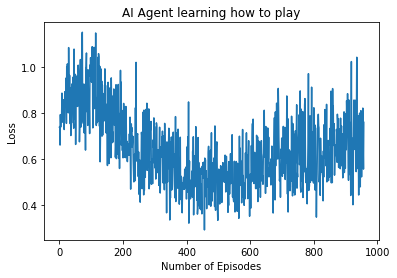

In [32]:
fig = plt.figure()
plt.plot( [i for i in range(len(agent_loss))], agent_loss)
plt.xlabel('Number of Episodes')
plt.ylabel('Loss')
plt.title('AI Agent learning how to play')

In [33]:
np.savetxt('.//v2_models/data-2-1000E_128BS.csv', agent_loss, delimiter=',')

In [108]:
env = Environment()
env.reset()
env.start()
time.sleep(2)
env.jump()
print(f"Episode ended? {env.is_crashed()}")
env.jump()
#images = env.get_screenshot()
#print(images.shape)
#env.view_screenshots(images)
time.sleep(2)
env.duck()
time.sleep(2)
#images = env.get_screenshot()
env.close_all()

D:\Programming\Python\Environments\py3.7_envs\AiPlaysDino\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: use options instead of chrome_options
  


Episode ended? False
Score is 22
Score is 33
Score is 43
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
Score is 51
No tasks found!


In [43]:
print(random.random())

0.03814215228614892


In [12]:
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [9]:
np.savetxt('.//data4.csv', agent_loss, delimiter=',')b = np.zeros((2, 3))

In [14]:
a[1, 1]

5

In [11]:
b[0, 1]

0.0

In [5]:
a = np.array([1, 2,3, 4])
a[1] = 666
a

array([  1, 666,   3,   4])

In [14]:
state = env.get_screenshot()
print(state.shape)

torch.Size([1, 4, 256, 128])


In [19]:
a = [1, 2,4 ,3]
b = a
a[1] = 9999
b


[1, 9999, 4, 3]

In [3]:
models = torch.load('.//v2_models/model.pt')
print(models['epsilon'])

0.01
